# Parte 3 del ejercicio del módulo 5

Este nb necesita, en mi PC
21:45

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif # Para SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error,root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import  f_regression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow import keras

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix


## Cargar el dataset

Repito algunos pasos del ejercicio de EDAS, porque son claves para poder trabajar.

In [2]:
# Cargar el dataset
file_path = "../Data/airbnb_nyc_clean.csv"  # Ruta del archivo subido
df = pd.read_csv(file_path)

Información del Dataset:
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 23 columns):

dtypes: bool(1), float64(11), int64(2), object(9)
memory usage: 11.7+ MB


###  Eliminar columnas id, host_id y host_name

In [3]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'house_rules','neighbourhood'], inplace=True, errors='ignore', axis=1)

print(df.shape)

(69305, 17)


### Separar por tipo de columnas en categóricas y numéricas

In [4]:
def marcar_num_columns(df):
    numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns.to_list() 
    print(numerical_columns)
    print(len(numerical_columns))
    return(numerical_columns)
numerical_columns = marcar_num_columns(df)  

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365']
12


In [5]:
def marcar_cat_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.to_list()
    print(categorical_columns)
    print(len(categorical_columns))
    return(categorical_columns)
categorical_columns = marcar_cat_columns(df)

['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type', 'last_review']
5


### Ver los nombres de las columnas

In [6]:
def indices_columnas(dataframe):
    df_index = df.keys()  # obtenemos los nombres de las columnas
    #print(df_index)
    return(df_index)

df_index = indices_columnas(df)

### Ver valores únicos de las columnas

In [7]:
def valores_unicos_all(df):
    # Find number of unique values in the dataset
    for col in df.columns:
        print(f'Column {col} \t has {df[col].nunique()} unique values')
        
valores_unicos_all(df)

Column host_identity_verified 	 has 2 unique values
Column neighbourhood_group 	 has 5 unique values
Column lat 	 has 21998 unique values
Column long 	 has 17780 unique values
Column instant_bookable 	 has 2 unique values
Column cancellation_policy 	 has 3 unique values
Column room_type 	 has 4 unique values
Column construction_year 	 has 20 unique values
Column price 	 has 1152 unique values
Column service_fee 	 has 232 unique values
Column minimum_nights 	 has 14 unique values
Column number_of_reviews 	 has 476 unique values
Column last_review 	 has 2472 unique values
Column reviews_per_month 	 has 1016 unique values
Column review_rate_number 	 has 5 unique values
Column calculated_host_listings_count 	 has 78 unique values
Column availability_365 	 has 437 unique values


In [8]:
marcar_cat_columns(df)

def valores_unicos_cat(df):
    categorical_columns = marcar_cat_columns(df)
    for col in categorical_columns:
        print('________________________________________________________')
        print(f"Valores únicos en la columna '{col}':")
        print('cantidad de valores únicos:', len(df[col].unique()))
        print(f'Los valores únicos de de la columna {col} son:', df[col].unique())
        print()
        print(df[col].unique())
        print(f'usando value_counts: {df[col].value_counts()}')
        print()
    return(categorical_columns)    
        
valores_unicos_cat(df)

['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type', 'last_review']
5
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type', 'last_review']
5
________________________________________________________
Valores únicos en la columna 'host_identity_verified':
cantidad de valores únicos: 2
Los valores únicos de de la columna host_identity_verified son: ['unconfirmed' 'verified']

['unconfirmed' 'verified']
usando value_counts: host_identity_verified
unconfirmed    34779
verified       34526
Name: count, dtype: int64

________________________________________________________
Valores únicos en la columna 'neighbourhood_group':
cantidad de valores únicos: 5
Los valores únicos de de la columna neighbourhood_group son: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
usando value_counts: neighbourhood_group
Manhattan        29587
Brooklyn         27895
Queens          

['host_identity_verified',
 'neighbourhood_group',
 'cancellation_policy',
 'room_type',
 'last_review']

### Vale la pena estudiar las categóricas siguientes:

**1. host_identity_verified: ['unconfirmed' 'verified']**

| Categoría    | Conteo |
|--------------|--------|
| unconfirmed  | 34779  |
| verified     | 34526  |

**2. neighbourhood_group: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']**

| Categoría     | Conteo |
|---------------|--------|
| Manhattan     | 29587  |
| Brooklyn      | 27895  |
| Queens        | 9262   |
| Bronx         | 1912   |
| Staten Island | 649    |

**3. cancellation_policy: ['strict' 'moderate' 'flexible']**

| Categoría  | Conteo |
|------------|--------|
| moderate   | 23244  |
| flexible   | 23126  |
| strict     | 22935  |

**4. room_type: ['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']**

| Categoría        | Conteo |
|------------------|--------|
| Entire home/apt  | 37212  |
| Private room     | 30508  |
| Shared room      | 1470   |
| Hotel room       | 115    |

### Fecha: probar a descomponer la fecha en campos año mes y día con pandas es decir, en 3 columnas, por ejemplo usando to_datetime de pandas y los accesores de fecha para extraer año mes y día.

In [9]:
# Convertir la columna de fecha `last_review` a tipo datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Crear nuevas columnas para año, mes y día
df['review_year'] = df['last_review'].dt.year
df['review_month'] = df['last_review'].dt.month
df['review_day'] = df['last_review'].dt.day

# Verificar cambios
print("Nuevas columnas creadas:")
print(df[['last_review', 'review_year', 'review_month', 'review_day']].head())

Nuevas columnas creadas:
  last_review  review_year  review_month  review_day
0  2021-10-19         2021            10          19
1  2022-05-21         2022             5          21
2  2019-06-14         2019             6          14
3  2019-07-05         2019             7           5
4  2018-11-19         2018            11          19


In [10]:
# Eliminar la columna original `last_review` si ya no es necesaria
df.drop(columns=['last_review'], inplace=True, errors='ignore')

In [11]:
df.head(1) # se crean las 3 nuevas columnas

,host_identity_verified,neighbourhood_group,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,review_year,review_month,review_day
0,unconfirmed,Brooklyn,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0,2021,10,19


### Quitar caracteres extraños de la columna barrio

In [ ]:
# quitar caracteres extraños de la columna barrio
# en esta versión hemos quitado esta columna desde el principio
#df['neighbourhood'] = df['neighbourhood'].str.replace('-', '').str.replace('"', '').str.replace("'", '').str.replace(' ', '_').str.replace('*',' ').str.replace('$',' ')

In [13]:
valores_unicos_all(df)

Column host_identity_verified 	 has 2 unique values
Column neighbourhood_group 	 has 5 unique values
Column lat 	 has 21998 unique values
Column long 	 has 17780 unique values
Column instant_bookable 	 has 2 unique values
Column cancellation_policy 	 has 3 unique values
Column room_type 	 has 4 unique values
Column construction_year 	 has 20 unique values
Column price 	 has 1152 unique values
Column service_fee 	 has 232 unique values
Column minimum_nights 	 has 14 unique values
Column number_of_reviews 	 has 476 unique values
Column reviews_per_month 	 has 1016 unique values
Column review_rate_number 	 has 5 unique values
Column calculated_host_listings_count 	 has 78 unique values
Column availability_365 	 has 437 unique values
Column review_year 	 has 11 unique values
Column review_month 	 has 12 unique values
Column review_day 	 has 31 unique values


In [14]:
valores_unicos_cat(df)

['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4
________________________________________________________
Valores únicos en la columna 'host_identity_verified':
cantidad de valores únicos: 2
Los valores únicos de de la columna host_identity_verified son: ['unconfirmed' 'verified']

['unconfirmed' 'verified']
usando value_counts: host_identity_verified
unconfirmed    34779
verified       34526
Name: count, dtype: int64

________________________________________________________
Valores únicos en la columna 'neighbourhood_group':
cantidad de valores únicos: 5
Los valores únicos de de la columna neighbourhood_group son: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
usando value_counts: neighbourhood_group
Manhattan        29587
Brooklyn         27895
Queens            9262
Bronx             1912
Staten Island      649
Name: count, dtype: int64

______________________________________

['host_identity_verified',
 'neighbourhood_group',
 'cancellation_policy',
 'room_type']

### Verificar estructura final del dataset y guardarlo

In [15]:
# Verificar estructura final del dataset
print("\n Dataset después del prepreprocesamiento:")
print(df.info())

# Guardar el dataset preprocesado
df.to_csv("dataset_limpio.csv", index=False)


 Dataset después del prepreprocesamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_identity_verified          69305 non-null  object 
 1   neighbourhood_group             69305 non-null  object 
 2   lat                             69305 non-null  float64
 3   long                            69305 non-null  float64
 4   instant_bookable                69305 non-null  bool   
 5   cancellation_policy             69305 non-null  object 
 6   room_type                       69305 non-null  object 
 7   construction_year               69305 non-null  float64
 8   price                           69305 non-null  float64
 9   service_fee                     69305 non-null  float64
 10  minimum_nights                  69305 non-null  float64
 11  number_of_reviews               69305 non-null  fl

In [16]:
categorical_columns = marcar_cat_columns(df)

['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4


Columnas categóricas útiles: ['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']


## Preprocesados (20%)

In [17]:
# pruebo a crear el modelo antes, para ver como mejora después
X_num = df[numerical_columns].drop('price', axis=1) 
# OJO solo uso las columnas numericas, salvo la q quiero predecir que es el precio
y_num = df['price']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.20, random_state=42)

df_resultados = pd.DataFrame(columns=['Modelo', 'Preprocesado', 'R2', 'MAE', 'RMSE', 'MAPE'])

def calculate_metrics(preprocessor_name, X_train_num, X_test_num, y_train_num, y_test_num):
    models = {
        'LinearRegression': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42)
    }
    for model_name, model in models.items():
        model.fit(X_train_num, y_train_num)
        y_pred_num = model.predict(X_test_num) # cada vez que llamo esta funcion se crea una prrediccion, pero no la estoy guardando ni haciendo transform
        df_resultados.loc[len(df_resultados)] = [model_name, preprocessor_name, r2_score(y_test_num, y_pred_num), mean_absolute_error(y_test_num, y_pred_num),root_mean_squared_error(y_test_num, y_pred_num),mean_absolute_percentage_error(y_test_num, y_pred_num)]
    
    return df_resultados.sort_values('R2', ascending=False)

In [18]:
print(numerical_columns)
print(categorical_columns)
categorical_columns_util = ['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
print(categorical_columns_util)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365']
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']


In [19]:
print(f"añadimos las nuevas columnas 'price_scaled' y 'number_of_reviews_scaled'")

# Escalar la columna 'price'
scaler = RobustScaler()
df['price_scaled'] = scaler.fit_transform(df[['price']])

# Escalar la columna 'number_of_reviews'
df['number_of_reviews_scaled'] = scaler.fit_transform(df[['number_of_reviews']])

añadimos las nuevas columnas 'price_scaled' y 'number_of_reviews_scaled'


#### OneHotEncoder

In [20]:
# Hay que volver a asignar valores a X y a y porque antes solo tenian los numericos
X_all = df.drop('price', axis=1)
y_all = df['price']

# y hacer el split entre entrenamiento y test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.20, random_state=42)

# obtener nombres de columnas numéricas y categóricas de X_train_all (sin price)
numerical_columns = marcar_num_columns(X_train_all)
categorical_columns = marcar_cat_columns(X_train_all)

#encoder = OneHotEncoder(sparse_output=False) # sparse_output=False para obtenerlo como matriz de 0s y 1s , probar drop='first'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # para ignorar cuando haya valores en test que no esten en train
X_train_encoded_OHE = encoder.fit_transform(X_train_all[categorical_columns]) # array de numpy con las codificaciones
X_test_encoded_OHE = encoder.transform(X_test_all[categorical_columns])

''' el OneHotEncoder encontró categorías en el conjunto de prueba (X_test) que no estaban presentes en el conjunto de entrenamiento (X_train) durante el proceso de transformación.'''
'''La forma más común de manejar este problema es configurar el parámetro handle_unknown del OneHotEncoder a 'ignore'. 
Esto le indica al encoder que ignore las categorías desconocidas en el conjunto de prueba y las codifique como columnas de ceros.'''

# pasarlo a dataframes de pandas y juntarlo con las numéricas para obtener resultado como pd.get_dummies
X_train_final_OHE = pd.concat(
    [
        pd.DataFrame(X_train_encoded_OHE, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        X_train_all[numerical_columns].reset_index(drop=True) # numéricas
    ],
    axis=1
)
X_test_final_OHE = pd.concat(
    [
        pd.DataFrame(X_test_encoded_OHE, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        X_test_all[numerical_columns].reset_index(drop=True) # numéricas
    ],
    axis=1
)

['lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
16
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4


In [21]:
print(X_train_all.columns)

Index(['host_identity_verified', 'neighbourhood_group', 'lat', 'long',
       'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'review_month', 'review_day', 'price_scaled',
       'number_of_reviews_scaled'],
      dtype='object')


In [22]:
print(X_train_encoded_OHE) #tenemos encoding de categoricas, falta incluirlas en el df TODO

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]]


In [23]:
calculate_metrics('OneHotEncoder', X_train_final_OHE, X_test_final_OHE, y_train_all, y_test_all)

,Modelo,Preprocesado,R2,MAE,RMSE,MAPE
0,LinearRegression,OneHotEncoder,1.000000,2.732060e-13,3.710784e-13,9.830486e-16
3,DecisionTree,OneHotEncoder,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
4,RandomForest,OneHotEncoder,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
1,KNN,OneHotEncoder,0.991370,1.220852e+01,3.072171e+01,3.474514e-02
2,SVR,OneHotEncoder,0.302544,2.384625e+02,2.761832e+02,8.507357e-01


#### Combinar OneHotEncoder con MinMaxScaler: ELEGIDO

In [24]:
# Combinar OneHotEncoder con MinMaxScaler
# Hay que volver a asignar valores a X y a y porque antes solo tenian los numericos
X_all = df.drop('price', axis=1)
y_all = df['price']

# y hacer el split entre entrenamiento y test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.20, random_state=42)

# obtener nombres de columnas numéricas y categóricas de X_train_all (sin price)
numerical_columns = marcar_num_columns(X_train_all)
categorical_columns = marcar_cat_columns(X_train_all)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse_output=False para obtenerlo como matriz de 0s y 1s , probar drop='first'
X_train_encoded_ohe = encoder.fit_transform(X_train_all[categorical_columns]) # array de numpy con las codificaciones
X_test_encoded_ohe = encoder.transform(X_test_all[categorical_columns])

scaler = MinMaxScaler()
X_train_scaled_mms = scaler.fit_transform(X_train_all[numerical_columns])
X_test_scaled_mms = scaler.transform(X_test_all[numerical_columns])

X_train_final_ohe_mms = pd.concat(
    [
        pd.DataFrame(X_train_encoded_ohe, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        pd.DataFrame(X_train_scaled_mms, columns=numerical_columns).reset_index(drop=True) # numéricas
    ],
    axis=1
)
X_test_final_ohe_mms = pd.concat(
    [
        pd.DataFrame(X_test_encoded_ohe, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        pd.DataFrame(X_test_scaled_mms, columns=numerical_columns).reset_index(drop=True) # numéricas
    ],
    axis=1
)

# Voy a elegir este preprocesado! X_train_final_ohe_mms etc

['lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
16
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4


In [25]:
X_train_final_ohe_mms.head(1)

,host_identity_verified_unconfirmed,host_identity_verified_verified,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,...,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,review_year,review_month,review_day,price_scaled,number_of_reviews_scaled
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.055664,0.016669,0.75,0.0,0.610092,0.7,0.363636,0.933333,0.284348,0.055664


In [26]:
X_train_final_ohe_mms.columns

Index(['host_identity_verified_unconfirmed', 'host_identity_verified_verified',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'lat', 'long',
       'instant_bookable', 'construction_year', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'review_year', 'review_month', 'review_day',
       'price_scaled', 'number_of_reviews_scaled'],
      dtype='object')

In [27]:
calculate_metrics('OneHotEncoder+MinMaxScaler', X_train_final_ohe_mms, X_test_final_ohe_mms, y_train_all, y_test_all)

,Modelo,Preprocesado,R2,MAE,RMSE,MAPE
0,LinearRegression,OneHotEncoder,1.000000,2.732060e-13,3.710784e-13,9.830486e-16
5,LinearRegression,OneHotEncoder+MinMaxScaler,1.000000,4.836730e-13,5.938713e-13,1.803472e-15
8,DecisionTree,OneHotEncoder+MinMaxScaler,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
3,DecisionTree,OneHotEncoder,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
9,RandomForest,OneHotEncoder+MinMaxScaler,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
4,RandomForest,OneHotEncoder,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
7,SVR,OneHotEncoder+MinMaxScaler,0.992398,1.708327e+01,2.883377e+01,6.623112e-02
1,KNN,OneHotEncoder,0.991370,1.220852e+01,3.072171e+01,3.474514e-02
6,KNN,OneHotEncoder+MinMaxScaler,0.929054,6.723309e+01,8.808532e+01,2.230652e-01
2,SVR,OneHotEncoder,0.302544,2.384625e+02,2.761832e+02,8.507357e-01


### Con pipeline

In [28]:
#Tenemos un columntransfer dentro del pipeline, que no admite arrays ni dataframe.
#por eso tengo que pasarle los numeros de las columnas
numerical_columns = marcar_num_columns(df)

X_num_pip = df[numerical_columns].drop('price', axis=1)
y_num_pip = df['price']

numerical_columns_sin_price = marcar_num_columns(X_num_pip)

# Dividir en conjuntos de entrenamiento y prueba
X_train_num_pip, X_test_num_pip, y_train_num_pip, y_test_num_pip = train_test_split(
    X_num_pip, y_num_pip, test_size=0.20, random_state=42
)

# Obtener índices numéricos de las columnas
column_indices = [X_num_pip.columns.get_loc(col) for col in numerical_columns_sin_price]

# Preprocesamiento numérico
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', ColumnTransformer([
        ('std', StandardScaler(), [column_indices[0], column_indices[1], column_indices[2], column_indices[5], column_indices[6], column_indices[7], column_indices[9], column_indices[10], column_indices[11], column_indices[12], column_indices[13], column_indices[14], column_indices[15]]), #Indices de las columnas que se escalan con standardscaler
        ('minmax', MinMaxScaler(), [column_indices[3], column_indices[4]]), #Indices de las columnas que se escalan con minmax
        ('quantile', QuantileTransformer(output_distribution='normal'), [column_indices[8]]) #Indice de la columna que se escala con QuantileTransformer
    ], remainder='passthrough'))
])

# Ajuste y transformación en el conjunto de entrenamiento
X_train_pipeline_num = numeric_pipeline.fit_transform(X_train_num_pip)

# Transformación en el conjunto de prueba
X_test_pipeline_num = numeric_pipeline.transform(X_test_num_pip)

# Imprimir nombres de columnas procesadas y escaladores en formato de tabla
print("Columnas procesadas:")
print("{:<10} {:<35} {:<20}".format("Índice", "Nombre de columna", "Escalador"))  # Encabezados
print("----------------------------------------------------------------")

for i, col_name in enumerate(numerical_columns_sin_price):
    if i in [0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]:
        scaler_name = "StandardScaler"
    elif i in [3, 4]:
        scaler_name = "MinMaxScaler"
    elif i == 8:
        scaler_name = "QuantileTransformer"
    else:
        scaler_name = "No se aplicó escalador"
    print("{:<10} {:<35} {:<20}".format(column_indices[i], col_name, scaler_name))

# Convertir a DataFrame (opcional)
X_train_pipeline_num = pd.DataFrame(X_train_pipeline_num, columns=numerical_columns_sin_price)
X_test_pipeline_num = pd.DataFrame(X_test_pipeline_num, columns=numerical_columns_sin_price)

print("----------------------------------------------------------------")
print(f"\nAsí queda X_train después de pasarle el pipeline:")
print(X_train_pipeline_num.head())
print("----------------------------------------------------------------")
print(f"\nAsí queda X_test después de pasarle el pipeline:")
print(X_test_pipeline_num.head())

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
17
['lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
16
Columnas procesadas:
Índice     Nombre de columna                   Escalador           
----------------------------------------------------------------
0          lat                                 StandardScaler      
1          long                                StandardScaler      
2          instant_bookable                    StandardScaler      
3          construction_year     

In [29]:
# pipeline para columnas categóricas
categorical_columns = marcar_cat_columns(df)

# Verificar que categorical_columns es una lista de strings
if not all(isinstance(col, str) for col in categorical_columns):
    raise ValueError("categorical_columns debe ser una lista de strings.")

# Definir la columna ordinal (si existe)
ordinal_col = 'columna_ordinal' if 'columna_ordinal' in categorical_columns else None

# Seleccionar las columnas categóricas para OneHotEncoding
onehot_cols = [col for col in categorical_columns if col != ordinal_col]

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de valores faltantes
    ('encoder', ColumnTransformer([
        ('ordinal', OrdinalEncoder(categories=[['valor1', 'valor2', 'valor3']]), ['columna_ordinal']), # Ejemplo: Codificación ordinal
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols) # Corrección: onehot_cols en lugar de df[categorical_columns].drop(...)
#        ('onehot', OneHotEncoder(handle_unknown='ignore'), df(categorical_columns).drop('columna_ordinal')) # Ejemplo: OneHotEncoding (se excluye la ordinal)
    ], remainder='passthrough')) #Las que no se especifiquen se mantienen sin escalar
])

['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4


In [30]:
print(numerical_columns_sin_price)
print(len(numerical_columns_sin_price))

['lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
16


In [31]:
df_transformed_pip_num = pd.DataFrame(numeric_pipeline.fit_transform(df[numerical_columns_sin_price]), columns=numeric_pipeline.get_feature_names_out())  # Aplicar solo a numéricas

In [32]:
df_transformed_pip_num.head(1) # este es bueno pero solo para numericas

,std__lat,std__long,std__instant_bookable,std__minimum_nights,std__number_of_reviews,std__reviews_per_month,std__calculated_host_listings_count,std__availability_365,std__review_year,std__review_month,std__review_day,std__price_scaled,std__number_of_reviews_scaled,minmax__construction_year,minmax__service_fee,quantile__review_rate_number
0,-1.439649,-0.462349,-0.993829,1.23476,-0.365215,-0.657858,-0.085519,0.988062,1.047381,1.430786,0.389278,1.030521,-0.365215,0.894737,0.795652,0.380326


### Ahora que tienes tus datos `X_train_pipeline_num` y `X_test_pipeline_num` procesados con el pipeline, el siguiente paso lógico es construir y entrenar un modelo de machine learning. Aquí te presento los pasos a seguir:

**1. Selección del modelo:**

* **Regresión:** Dado que estás intentando predecir el precio, un valor numérico continuo, necesitas un modelo de regresión. Algunas opciones populares son:
    * Regresión Lineal
    * Random Forest Regressor
    * Gradient Boosting Regressor (por ejemplo, XGBoost, LightGBM)
    * Support Vector Regression (SVR)
    
* **Consideraciones:** La elección del modelo depende de varios factores, como la complejidad de tus datos, la interpretabilidad deseada y el rendimiento esperado.

**2. Entrenamiento del modelo:**

* **Ajuste del modelo:** Utiliza el método `fit()` del modelo seleccionado para entrenarlo con tus datos de entrenamiento `X_train_pipeline_num` y la variable objetivo `y_train_num_pip`.
* **Ejemplo (Random Forest Regressor):**

In [33]:
model_RF = RandomForestRegressor(random_state=42)
model_RF.fit(X_train_pipeline_num, y_train_num_pip)

RandomForestRegressor(random_state=42)

In [34]:
calculate_metrics('RandomForest after pipeline', X_train_pipeline_num, X_test_pipeline_num, y_train_num_pip, y_test_num_pip)

,Modelo,Preprocesado,R2,MAE,RMSE,MAPE
0,LinearRegression,OneHotEncoder,1.000000,2.732060e-13,3.710784e-13,9.830486e-16
5,LinearRegression,OneHotEncoder+MinMaxScaler,1.000000,4.836730e-13,5.938713e-13,1.803472e-15
10,LinearRegression,RandomForest after pipeline,1.000000,3.864540e-13,4.728069e-13,1.183471e-15
8,DecisionTree,OneHotEncoder+MinMaxScaler,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
3,DecisionTree,OneHotEncoder,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
14,RandomForest,RandomForest after pipeline,1.000000,9.147969e-04,2.649416e-02,2.119070e-06
4,RandomForest,OneHotEncoder,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
9,RandomForest,OneHotEncoder+MinMaxScaler,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
13,DecisionTree,RandomForest after pipeline,1.000000,3.607243e-04,3.062488e-02,5.782975e-07
7,SVR,OneHotEncoder+MinMaxScaler,0.992398,1.708327e+01,2.883377e+01,6.623112e-02


In [35]:
#Hacemos una predicción del precio con el modelo que hemos entrenado
y_pred = model_RF.predict(X_test_pipeline_num)

r2 = r2_score(y_test_num_pip, y_pred)
mse = mean_squared_error(y_test_num_pip, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num_pip, y_pred)
mape = mean_absolute_percentage_error(y_test_num_pip, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

R²: 1.0000
MSE: 0.0007
RMSE: 0.0265
MAE: 0.0009
MAPE: 0.0000


In [36]:
print(numeric_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  [0, 1, 2, 5, 6, 7, 9, 10, 11,
                                                   12, 13, 14, 15]),
                                                 ('minmax', MinMaxScaler(),
                                                  [3, 4]),
                                                 ('quantile',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  [8])]))])


In [37]:
print(categoric_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['valor1',
                                                                              'valor2',
                                                                              'valor3']]),
                                                  ['columna_ordinal']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['host_identity_verified',
                                                   'neighbourhood_group',
                                                   'cancellation_policy',
                                                   'room_type'])]))

In [38]:
print(numerical_columns)
print(categorical_columns)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']


In [39]:
# Transformación de datos
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_columns),
    ('cat', categoric_pipeline, categorical_columns)
])

In [40]:
#  Aplicación del preprocesamiento
# df_transformed = pd.DataFrame(preprocessor.fit_transform(df), columns=preprocessor.get_feature_names_out())

In [41]:
df_transformed_pip_num.head(1)

,std__lat,std__long,std__instant_bookable,std__minimum_nights,std__number_of_reviews,std__reviews_per_month,std__calculated_host_listings_count,std__availability_365,std__review_year,std__review_month,std__review_day,std__price_scaled,std__number_of_reviews_scaled,minmax__construction_year,minmax__service_fee,quantile__review_rate_number
0,-1.439649,-0.462349,-0.993829,1.23476,-0.365215,-0.657858,-0.085519,0.988062,1.047381,1.430786,0.389278,1.030521,-0.365215,0.894737,0.795652,0.380326


### 3️⃣ Resumen del Preprocesamiento

✅ Columnas Numéricas: Se ha aplicado imputación y escalado con SimpleImputer y StandardScaler.

✅ Columnas Categóricas:

    * OrdinalEncoder para room_type. COMPROBAR
    * OneHotEncoder para neighbourhood_group y neighbourhood. COMPROBAR TO DO

Ahora los datos están listos para la siguiente fase de análisis y modelado! 

*Aquí ya tengo que tener el dataframe listo!!! o la matriz X_train X_test*

### Finalmente me quedo con el resultado de usar OneHotEncoder, y MinMaxScaler

X_train_final_ohe_mms

X_test_final_ohe_mms

y_train_all

y_test_all

Pero hay que asociar bien los 4 dataframes en uno


In [42]:
print(type(X_train_final_ohe_mms))
print(type(X_test_final_ohe_mms))
print(type(y_train_all))
print(type(y_test_all))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [43]:
X_train_final_ohe_mms.head(1)

,host_identity_verified_unconfirmed,host_identity_verified_verified,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,...,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,review_year,review_month,review_day,price_scaled,number_of_reviews_scaled
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.055664,0.016669,0.75,0.0,0.610092,0.7,0.363636,0.933333,0.284348,0.055664


In [44]:
# Asumiendo que tienes X_train_final_ohe_mms, X_test_final_ohe_mms,
# y_train_all e y_test_all como arrays de NumPy o Series de pandas

# 1. Convertir a DataFrames y Series
X_train_df = pd.DataFrame(X_train_final_ohe_mms)
X_test_df = pd.DataFrame(X_test_final_ohe_mms)

if isinstance(y_train_all, np.ndarray):
    y_train_series = pd.Series(y_train_all)
else:
    y_train_series = y_train_all

if isinstance(y_test_all, np.ndarray):
    y_test_series = pd.Series(y_test_all)
else:
    y_test_series = y_test_all

# 2. Añadir la variable objetivo
X_train_df['price'] = y_train_series
X_test_df['price'] = y_test_series

# 3. Concatenar los DataFrames
df_final = pd.concat([X_train_df, X_test_df], ignore_index=True)

# Imprimir las primeras filas del DataFrame resultante
print(df_final.head())

   host_identity_verified_unconfirmed  host_identity_verified_verified  \
0                                 1.0                              0.0   
1                                 0.0                              1.0   
2                                 1.0                              0.0   
3                                 1.0                              0.0   
4                                 1.0                              0.0   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                        0.0                           0.0   
1                        0.0                           1.0   
2                        0.0                           0.0   
3                        0.0                           0.0   
4                        0.0                           1.0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                            1.0                         0.0   
1                            0.0                      

In [45]:
print('Nos quedamos con el dataframe df_final, con OneHotEncoder y MinMaxScaler')
print(df_final.head(1))

Nos quedamos con el dataframe df_final, con OneHotEncoder y MinMaxScaler
   host_identity_verified_unconfirmed  host_identity_verified_verified  \
0                                 1.0                              0.0   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                        0.0                           0.0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                            1.0                         0.0   

   neighbourhood_group_Staten Island  cancellation_policy_flexible  \
0                                0.0                           0.0   

   cancellation_policy_moderate  cancellation_policy_strict  ...  \
0                           0.0                         1.0  ...   

   reviews_per_month  review_rate_number  calculated_host_listings_count  \
0           0.016669                0.75                             0.0   

   availability_365  review_year  review_month  review_day  price_scaled  \
0          0.6100

## Clustering y siluetas (10 %)

### Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering


In [46]:
df_index_final = indices_columnas(df_final)

In [47]:
print(df_index)
print(len(df_index))

Index(['host_identity_verified', 'neighbourhood_group', 'lat', 'long',
       'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')
17


In [48]:
print(df_index_final)
print(len(df_index_final))

Index(['host_identity_verified', 'neighbourhood_group', 'lat', 'long',
       'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'review_month', 'review_day', 'price_scaled',
       'number_of_reviews_scaled'],
      dtype='object')
21


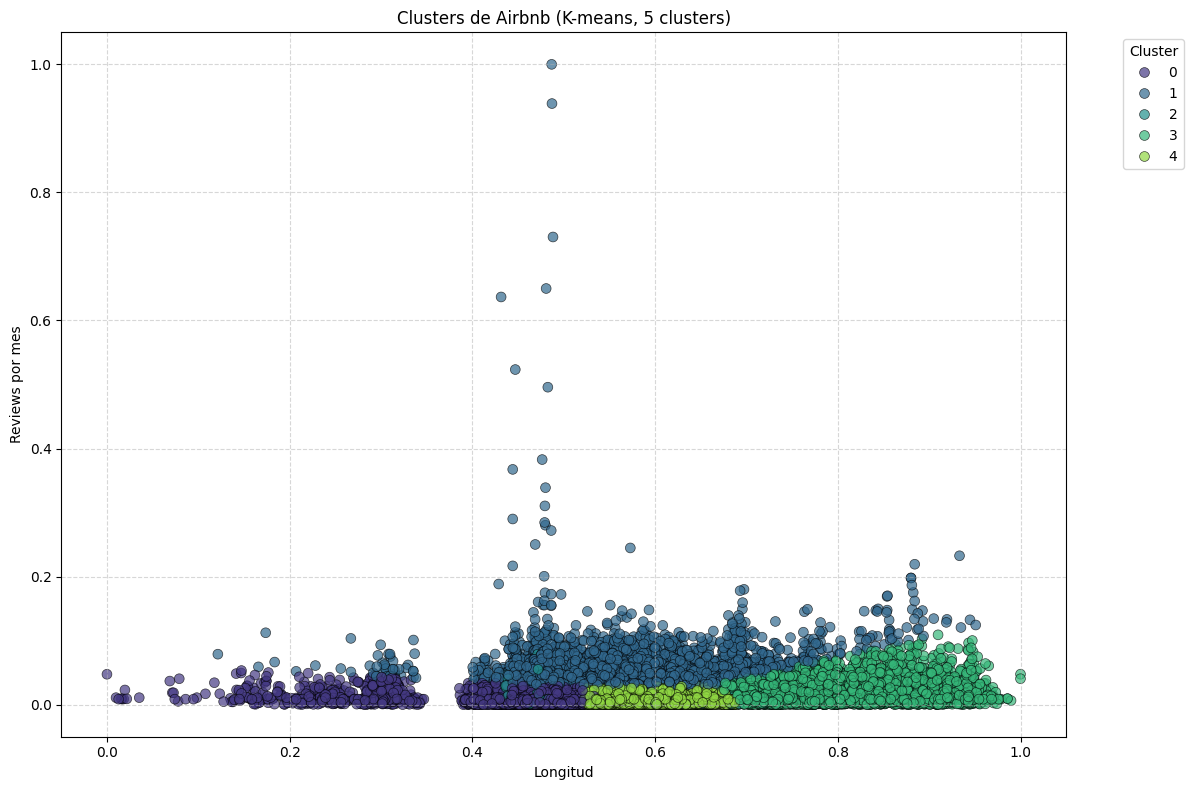

In [49]:
# Variables para clustering
variables_cluster = ["long", "reviews_per_month", "calculated_host_listings_count"]

# Preprocesamiento
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final[variables_cluster])

# Clustering (ejemplo: k-means)
n_clusters = 5  # Aumentar el número de clusters para una mejor diferenciación
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_final['cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar clusters mejorado
plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura para mejor visualización
sns.scatterplot(
    df_final,
    x="long",
    y="reviews_per_month",
    hue="cluster",
    palette=sns.color_palette("viridis", n_clusters),  # Usar una paleta de colores con el número correcto de clusters
    s=50,  # Aumentar el tamaño de los puntos para mejor visibilidad
    alpha=0.7,  # Añadir transparencia para evitar sobreposición de puntos
    edgecolor='black',  # Añadir bordes a los puntos para mejor diferenciación
    linewidth=0.5  # Ajustar el grosor de los bordes
)

plt.title(f"Clusters de Airbnb (K-means, {n_clusters} clusters)")
plt.xlabel("Longitud")
plt.ylabel("Reviews por mes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Guardar la figura con los valores
filename = f"clusters_airbnb_kmeans_{n_clusters}_clusters.png"
plt.savefig(filename, bbox_inches='tight')

plt.show()

In [50]:
# Aplicación de K-Means en el dataframe original
n_clusters = 5 # numero de valores distintos de neighbourhood_group
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['lat', 'long']])

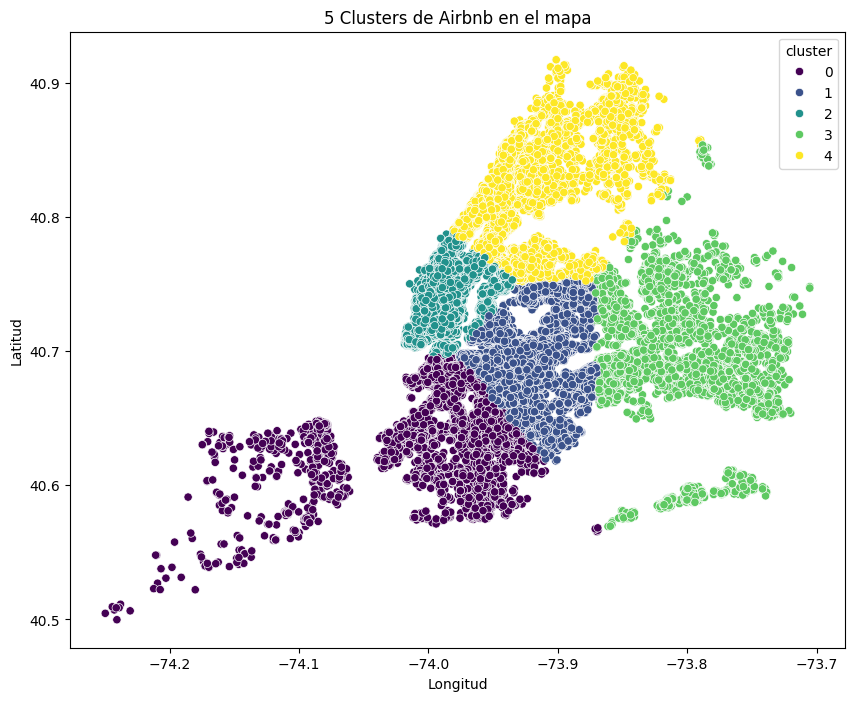

In [51]:
# Visualización con Scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='long', y='lat', hue='cluster', data=df, palette='viridis')
plt.title(f'{n_clusters} Clusters de Airbnb en el mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
# Guardar la figura con los valores
filename = f"clusters_airbnb_kmeans_{n_clusters}_clusters_lat_long.png"
plt.savefig(filename, bbox_inches='tight')
plt.show()

In [52]:
print(numerical_columns)
print(categorical_columns)
marcar_num_columns(df_final)
marcar_cat_columns(df_final)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled']
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listi

[]

In [53]:
ordinal_col = 'columna_ordinal' if 'columna_ordinal' in categorical_columns else None
print(ordinal_col)

None


In [54]:
# Columnas numéricas
numerical_columns = marcar_num_columns(df)
# Pipeline numérico
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Columnas categóricas
categorical_columns = marcar_cat_columns(df)
# pero vamos a quitar los barrios
categorical_columns = categorical_columns_util
# Columnas para OneHotEncoding
#onehot_cols = ['host_identity_verified', 'neighbourhood_group', 'instant_bookable', 'cancellation_policy', 'room_type']
onehot_cols = [col for col in categorical_columns if col != ordinal_col]

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_columns),
    ('cat', categoric_pipeline, onehot_cols)
])

# Aplicar preprocesamiento
df_transformed_array = preprocessor.fit_transform(df)

# Obtener nombres de las columnas después del OneHotEncoding
num_names = numerical_columns
cat_names = []
#ohe = categoric_pipeline.named_steps['onehot']
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot'] #Accede al ohe desde el preprocessor ya fitteado

encoded_cat_names = ohe.get_feature_names_out(input_features = onehot_cols)
cat_names.extend(encoded_cat_names)

all_names = num_names + list(cat_names)

df_transformed = pd.DataFrame(df_transformed_array, columns = all_names)

print(df_transformed.head())

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster']
18
['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
4
        lat      long  instant_bookable  construction_year     price  \
0 -1.439649 -0.462349         -0.993829           1.304789  1.030521   
1  0.456468 -0.688228         -0.993829          -0.953684 -1.457728   
2  1.446243  0.141383          1.006209          -1.301141 -0.014302   
3 -0.766994 -0.212495          1.006209          -1.301141 -0.775271   
4  1.258472  0.099971         -0.993829          -0.606227 -1.270505   

   service_fee  minimum_nights  number_of_reviews  reviews_per_month  \
0     1.028444        1.234760          -0.365215          -0.657858   
1    -1.463163 

In [55]:
marcar_num_columns(df_final)

['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'price', 'cluster']
32


['host_identity_verified_unconfirmed',
 'host_identity_verified_verified',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'lat',
 'long',
 'instant_bookable',
 'construction_year',
 'service_fee',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'review_rate_number',
 'calculated_host_listings_count',
 'availability_365',
 'review_year',
 'review_month',
 'review_day',
 'price_scaled',
 'number_of_reviews_scaled',
 'price',
 'cluster']

In [56]:
print(f"Las columnas categóricas sobre las que hemos hecho OneHotEncoder son: {categorical_columns}")
print(f"onehot_cols: {onehot_cols}")
print(f"número de columnas: {len(categorical_columns)}")
marcar_cat_columns(df_final) # ya no tiene porque las hemos transformado en columnas con 0 y 1
print(f"\nlas columnas categóricas que se van a añadir son: {cat_names}")
print(f"que son {len(cat_names)}")
print(f" por lo tanto se van a añadir {len(cat_names)-len(onehot_cols)} columnas")
print(f"\n y las {len(categorical_columns)} columnas categóricas pasan a ser {len(encoded_cat_names)} {encoded_cat_names}")

Las columnas categóricas sobre las que hemos hecho OneHotEncoder son: ['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
onehot_cols: ['host_identity_verified', 'neighbourhood_group', 'cancellation_policy', 'room_type']
número de columnas: 4
[]
0

las columnas categóricas que se van a añadir son: ['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
que son 14
 por lo tanto se van a añadir 10 columnas

 y las 4 columnas categóricas pasan a ser 14 ['host_identity_verified_unconfirmed' 'host_identity_verified_verified'
 'neighbourhood_group_Bronx' 'neighbourhood_group_Brooklyn'
 'n

In [57]:
print(f"{all_names}")
print(f"incluyendo las {len(numerical_columns)}  col numericas tendremos {len(all_names)} en total")

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
incluyendo las 18  col numericas tendremos 32 en total


In [58]:
marcar_num_columns(df_final)

['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'price', 'cluster']
32


['host_identity_verified_unconfirmed',
 'host_identity_verified_verified',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'lat',
 'long',
 'instant_bookable',
 'construction_year',
 'service_fee',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'review_rate_number',
 'calculated_host_listings_count',
 'availability_365',
 'review_year',
 'review_month',
 'review_day',
 'price_scaled',
 'number_of_reviews_scaled',
 'price',
 'cluster']

In [59]:
marcar_cat_columns(df_final)

[]
0


[]

In [60]:
print(all_names)
print(len(all_names))

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
32


### Clustering y análisis de silueta (por separado para cada combinación de variables)

### Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot


Coeficiente de silueta (Ejemplo 1): 0.24346260587080262
Gráfico guardado como: coeficiente de silueta por precio propiedad y ubic 5 clusters.png


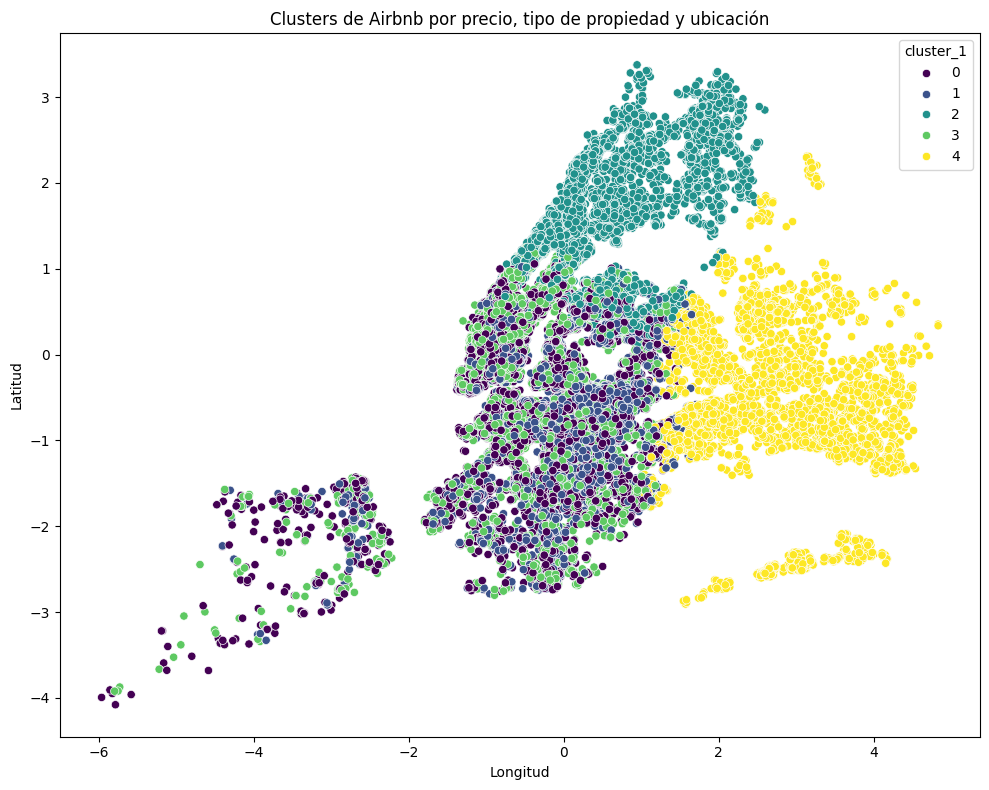

In [61]:
# Clustering y análisis de silueta (por separado para cada combinación de variables)

#  Ejemplo 1: Precio, tipo de propiedad y ubicación
features_1 = ['price', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room',  'lat', 'long']
n_clusters_1 = 5

# Escalar 'price' si es necesario (ya se escaló en el preprocesamiento general)
# scaler_price = StandardScaler()

kmeans_1 = KMeans(n_clusters=n_clusters_1, random_state=42)
df_transformed['cluster_1'] = kmeans_1.fit_predict(df_transformed[features_1])

silhouette_avg_1 = silhouette_score(df_transformed[features_1], df_transformed['cluster_1'])
print(f"Coeficiente de silueta (Ejemplo 1): {silhouette_avg_1}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x='long', y='lat', hue='cluster_1', data=df_transformed, palette='viridis')
plt.title('Clusters de Airbnb por precio, tipo de propiedad y ubicación')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
filename = f"coeficiente de silueta por precio propiedad y ubic {n_clusters_1} clusters.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Gráfico guardado como: {filename}")
plt.tight_layout()
plt.show()

Coeficiente de silueta (Ejemplo 2): 0.35413161351508216
Gráfico guardado como: coeficiente de silueta por reput y precio 5 clusters.png


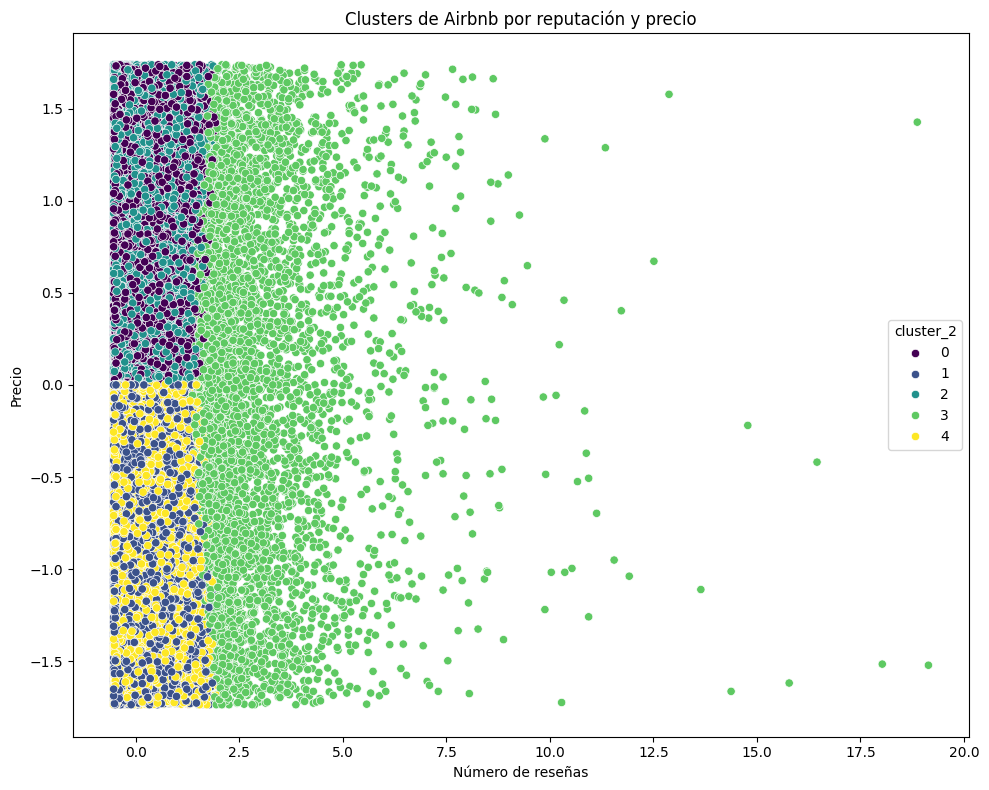

In [62]:
# Ejemplo 2: Reputación y precio
features_2 = ['number_of_reviews', 'review_rate_number', 'price']
n_clusters_2 = 5

kmeans_2 = KMeans(n_clusters=n_clusters_2, random_state=42)
df_transformed['cluster_2'] = kmeans_2.fit_predict(df_transformed[features_2])

silhouette_avg_2 = silhouette_score(df_transformed[features_2], df_transformed['cluster_2'])
print(f"Coeficiente de silueta (Ejemplo 2): {silhouette_avg_2}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x='number_of_reviews', y='price', hue='cluster_2', data=df_transformed, palette='viridis')
plt.title('Clusters de Airbnb por reputación y precio')
plt.xlabel('Número de reseñas')
plt.ylabel('Precio')
filename = f"coeficiente de silueta por reput y precio {n_clusters_2} clusters.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Gráfico guardado como: {filename}")
plt.tight_layout()
plt.show()

In [63]:
'''# Ejemplo 3: Comodidades y tipo de propiedad
features_3 = [ 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'instant_bookable', 'availability_365', 'minimum_nights', 'service_fee', 'cancellation_policy_flexible']
n_clusters_3 = 4  # Ajusta este valor

kmeans_3 = KMeans(n_clusters=n_clusters_3, random_state=42)
df_transformed['cluster_3'] = kmeans_3.fit_predict(df_transformed[features_3])

silhouette_avg_3 = silhouette_score(df_transformed[features_3], df_transformed['cluster_3'])
print(f"Coeficiente de silueta (Ejemplo 3): {silhouette_avg_3}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x='minimum_nights', y='availability_365', hue='cluster_3', data=df_transformed, palette='viridis')
plt.title('Clusters de Airbnb por comodidades y tipo de propiedad')
plt.xlabel('mínimo número de noches')
plt.ylabel('Disponibilidad')
# Guardar el gráfico ANTES de mostrarlo
filename = f"coeficiente de silueta por comodidades y tipo de prop {n_clusters_3} clusters.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Gráfico guardado como: {filename}")

plt.tight_layout()
plt.show()'''

'# Ejemplo 3: Comodidades y tipo de propiedad\nfeatures_3 = [ \'room_type_Entire home/apt\', \'room_type_Hotel room\', \'room_type_Private room\', \'room_type_Shared room\', \'instant_bookable\', \'availability_365\', \'minimum_nights\', \'service_fee\', \'cancellation_policy_flexible\']\nn_clusters_3 = 4  # Ajusta este valor\n\nkmeans_3 = KMeans(n_clusters=n_clusters_3, random_state=42)\ndf_transformed[\'cluster_3\'] = kmeans_3.fit_predict(df_transformed[features_3])\n\nsilhouette_avg_3 = silhouette_score(df_transformed[features_3], df_transformed[\'cluster_3\'])\nprint(f"Coeficiente de silueta (Ejemplo 3): {silhouette_avg_3}")\n\nplt.figure(figsize=(10, 8))\nsns.scatterplot(x=\'minimum_nights\', y=\'availability_365\', hue=\'cluster_3\', data=df_transformed, palette=\'viridis\')\nplt.title(\'Clusters de Airbnb por comodidades y tipo de propiedad\')\nplt.xlabel(\'mínimo número de noches\')\nplt.ylabel(\'Disponibilidad\')\n# Guardar el gráfico ANTES de mostrarlo\nfilename = f"coeficien

## feature selection (10%)

### Selección de características: ¿Por qué es importante?

* **Reducción de la dimensionalidad**: Menos características pueden simplificar los modelos y reducir el tiempo de entrenamiento.
* **Mejora del rendimiento**: Eliminar características irrelevantes o redundantes puede mejorar la precisión del modelo.
* **Comprensión del modelo**: Un modelo más simple es más fácil de interpretar.

#### **Técnicas de selección de características:**

1.  **SelectKBest**:
    * Este método selecciona las K mejores características basándose en pruebas estadísticas univariadas.
    * Para regresión, puedes usar pruebas como f_regression o mutual_info_regression.
    * Es útil para filtrar rápidamente las características más relevantes.

### SelectKBest para filtrar las mejores columnas y probar - Probar este para regresión

In [64]:
df_final.head(1) #le faltan columnas numéricas

,host_identity_verified_unconfirmed,host_identity_verified_verified,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,...,review_rate_number,calculated_host_listings_count,availability_365,review_year,review_month,review_day,price_scaled,number_of_reviews_scaled,price,cluster
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.75,0.0,0.610092,0.7,0.363636,0.933333,0.284348,0.055664,966.0,4


In [65]:
df_final.columns

Index(['host_identity_verified_unconfirmed', 'host_identity_verified_verified',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'lat', 'long',
       'instant_bookable', 'construction_year', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365', 'review_year', 'review_month', 'review_day',
       'price_scaled', 'number_of_reviews_scaled', 'price', 'cluster'],
      dtype='object')

In [66]:
numerical_columns = marcar_num_columns(df_final)

X_num = df_final[numerical_columns].drop('price', axis=1) 
y_num = df_final['price']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.20, random_state=42)

['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'lat', 'long', 'instant_bookable', 'construction_year', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'price', 'cluster']
32


In [67]:
df_transformed.head(1)

,lat,long,instant_bookable,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,...,neighbourhood_group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster_1,cluster_2
0,-1.439649,-0.462349,-0.993829,1.304789,1.030521,1.028444,1.23476,-0.365215,-0.657858,0.540212,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0


In [68]:
df_transformed.columns

Index(['lat', 'long', 'instant_bookable', 'construction_year', 'price',
       'service_fee', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'review_month', 'review_day', 'price_scaled',
       'number_of_reviews_scaled', 'cluster',
       'host_identity_verified_unconfirmed', 'host_identity_verified_verified',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'cluster_1',
       'cluster_2'],
      dtype='object')

In [69]:
numerical_columns = marcar_num_columns(df_transformed)

X_num = df_transformed[numerical_columns].drop('price', axis=1) 
y_num = df_transformed['price']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.20, random_state=42)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'cluster_1', 'cluster_2']
34


In [70]:
selector = SelectKBest(f_regression, k=5)  # Selecciona las 5 mejores características
X_new = selector.fit_transform(X_num, y_num)

# Obtener las puntuaciones de las características
scores = selector.scores_
# Obtener las características seleccionadas
selected_features = selector.get_support(indices=True)

print("Puntuaciones de las características:", scores)
print("Características seleccionadas:", selected_features)

Puntuaciones de las características: [1.25372973e+00 1.77804619e+00 7.50024150e-03 1.87524972e-01
 1.17850164e+07 2.64763846e-01 2.99589998e+00 1.78638389e+00
 1.57225955e-01 2.45679508e-02 2.20727791e-01 3.29661107e-01
 8.57639804e-01 6.23991398e-01 5.20188275e+19 2.99589998e+00
 2.26754890e-01 1.00540782e+00 1.00540782e+00 4.05399923e-01
 1.00961175e+00 3.26888080e+00 9.74827385e-01 1.61599389e-01
 3.91611794e-02 6.28777861e-02 2.02410385e-01 1.12495794e-01
 1.82259610e+00 6.85778221e-02 1.50911319e-02 2.55708007e+04
 1.12628509e+04]
Características seleccionadas: [ 4 14 21 31 32]


#### `SelectKBest` es una técnica de selección de características univariante que funciona seleccionando las "k" mejores características de un conjunto de datos, basándose en pruebas estadísticas. Aquí te explico cómo funciona:

**Proceso general:**

1.  **Evaluación univariante:**
    * `SelectKBest` evalúa cada característica individualmente, en relación con la variable objetivo.
    * Utiliza pruebas estadísticas univariantes para medir la relación entre cada característica y la variable objetivo.
    * La prueba estadística específica que se utiliza depende del tipo de problema (regresión o clasificación) y del tipo de datos (numéricos o categóricos).

2.  **Puntuación de las características:**
    * Cada característica recibe una puntuación basada en la prueba estadística.
    * Las puntuaciones indican la fuerza de la relación entre la característica y la variable objetivo.

3.  **Selección de las mejores características:**
    * `SelectKBest` selecciona las "k" características con las puntuaciones más altas.
    * "k" es un parámetro que debes especificar, indicando el número de características que deseas seleccionar.

**Pruebas estadísticas utilizadas:**

* **Para regresión:**
    * `f_regression`: Calcula la puntuación F para la regresión.
    * `mutual_info_regression`: Calcula la información mutua entre cada característica y la variable objetivo.
* **Para clasificación:**
    * `chi2`: Calcula la prueba chi-cuadrado para características no negativas.
    * `f_classif`: Calcula la puntuación F para la clasificación.
    * `mutual_info_classif`: Calcula la información mutua entre cada característica y la variable objetivo.

**Parámetros importantes:**

* **`score_func`:** La función de puntuación que se utiliza para evaluar las características (por ejemplo, `f_regression`, `chi2`).
* **`k`:** El número de características que se seleccionarán.


#### **Ventajas:**

* Es fácil de usar y rápido.
* Puede ser útil para filtrar rápidamente las características más relevantes.

**Desventajas:**

* Evalúa las características individualmente, sin considerar las interacciones entre ellas.
* Puede no ser adecuado para problemas con muchas características correlacionadas.

**Consideraciones:**

* La elección de la función de puntuación y el valor de "k" depende del tipo de problema y de los datos.
* Es importante evaluar el rendimiento del modelo con las características seleccionadas para determinar si la selección de características es beneficiosa.


### PCA - Probar este para clasificación
PCA (Análisis de Componentes Principales):
    * PCA es una técnica de reducción de dimensionalidad que transforma las características originales en un conjunto de componentes principales ortogonales.
    * Es útil para clasificación cuando tienes muchas características correlacionadas.


#### ver ejercicio 56.PCA_digits

In [71]:
print(all_names)
print(cat_names)
X_cat_n = df_transformed[cat_names]

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
['host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_po

In [72]:
pca = PCA(n_components=5)  # Selecciona 5 componentes principales
X_pca = pca.fit_transform(X_cat_n)  

### probar los dos pero quedarse con uno, o comparar resultados con ambos


In [73]:
numerical_columns = marcar_num_columns(df_transformed)

X_num = df_transformed[numerical_columns].drop('price', axis=1) 
y_num = df_transformed['price']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.20, random_state=42)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'cluster_1', 'cluster_2']
34


In [74]:
# SelectKBest
selector = SelectKBest(f_regression, k=5)
X_train_kbest = selector.fit_transform(X_train_num, y_train_num)
X_test_kbest = selector.transform(X_test_num)

# Obtener las puntuaciones de las características
scores = selector.scores_
# Obtener las características seleccionadas
selected_features = selector.get_support(indices=True)
print("Puntuaciones de las características:", scores)
print("Características seleccionadas:", selected_features)

model_kbest = LinearRegression()
model_kbest.fit(X_train_kbest, y_train_num)
y_pred_kbest = model_kbest.predict(X_test_kbest)

r2_kbest = r2_score(y_test_num, y_pred_kbest)
mse_kbest = mean_squared_error(y_test_num, y_pred_kbest)
rmse_kbest = np.sqrt(mse_kbest)
mae_kbest = mean_absolute_error(y_test_num, y_pred_kbest)

# Comparación de resultados
print("SelectKBest:")
print(f"  R²: {r2_kbest:.4f}")
print(f"  MSE: {mse_kbest:.4f}")
print(f"  RMSE: {rmse_kbest:.4f}")
print(f"  MAE: {mae_kbest:.4f}")

Puntuaciones de las características: [4.99545727e-01 1.49426873e+00 1.31834016e-01 1.94709045e-01
 9.40302848e+06 4.26435749e-02 3.49647138e+00 1.94559640e+00
 5.37584873e-01 9.66821397e-02 3.04828808e-03 1.47718978e-01
 7.02477795e-01 8.64547317e-01 5.20184522e+18 3.49647138e+00
 8.24088145e-03 9.34258987e-02 9.34258987e-02 2.78527096e-01
 6.16874780e-01 2.29512729e+00 8.76567690e-01 1.84942412e-01
 6.66938363e-02 9.56174246e-01 1.53839464e+00 1.56186318e-01
 1.69269422e+00 2.87317685e-01 7.01568281e-01 2.05100335e+04
 8.98076860e+03]
Características seleccionadas: [ 4 14 15 31 32]
SelectKBest:
  R²: 1.0000
  MSE: 0.0000
  RMSE: 0.0000
  MAE: 0.0000


In [75]:
# PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_num)
X_test_pca = pca.transform(X_test_num)

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_num)
y_pred_pca = model_pca.predict(X_test_pca)

r2_pca = r2_score(y_test_num, y_pred_pca)
mse_pca = mean_squared_error(y_test_num, y_pred_pca)
rmse_pca = np.sqrt(mse_pca)
mae_pca = mean_absolute_error(y_test_num, y_pred_pca)

print("\nPCA:")
print(f"  R²: {r2_pca:.4f}")
print(f"  MSE: {mse_pca:.4f}")
print(f"  RMSE: {rmse_pca:.4f}")
print(f"  MAE: {mae_pca:.4f}")


PCA:
  R²: 0.7713
  MSE: 0.2280
  RMSE: 0.4775
  MAE: 0.3717


En esta comparación entre SelectKBest y PCA sale ganando la primera

## Regresión (20%):

In [76]:
numerical_columns = marcar_num_columns(df_transformed)

X_num = df_transformed[numerical_columns].drop('price', axis=1) 
y_num = df_transformed['price']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.20, random_state=42)

['lat', 'long', 'instant_bookable', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'review_year', 'review_month', 'review_day', 'price_scaled', 'number_of_reviews_scaled', 'cluster', 'host_identity_verified_unconfirmed', 'host_identity_verified_verified', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'cluster_1', 'cluster_2']
34


In [77]:
# Algoritmo de regresión lineal de sklearn
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train_num, y_train_num)
# Encontramos los coeficientes de la recta  
print ("w_1:", regresion_lineal.coef_)
print ("w_0:", regresion_lineal.intercept_)

w_1: [-4.50988340e-17  4.83120488e-16  1.56698277e-16 -3.38666602e-16
  1.82102756e-15  2.04378694e-16 -1.04925705e-15  1.67894552e-16
 -4.00543166e-16  3.98961735e-16  2.47085712e-16  3.97930673e-16
  1.52063125e-16  1.43600900e-16  1.00000000e+00  8.41572755e-16
 -2.96787890e-16  3.31457976e-16  2.45840524e-16 -1.12947370e-15
 -9.74989196e-16 -3.55830637e-16 -7.23958057e-16  3.73428516e-16
  1.53911057e-16  9.87674424e-17  2.21005210e-16 -1.72352412e-16
 -4.12609943e-16 -9.47659512e-17 -1.25258268e-16  1.79424161e-16
 -4.99812985e-16]
w_0: 9.883587004377858e-16


### Predecir la columna 'price'

In [78]:
y_pred_rl = regresion_lineal.predict(X_test_num)

for i, j in zip(y_pred_rl[:20], y_test_num[:20]):
    print(f"Predicción: {i:20} \tValor real: {j} \tDiferencia: {i-j}")

Predicción:   1.0848764207840969 	Valor real: 1.0848764207840975 	Diferencia: -6.661338147750939e-16
Predicción:   0.9550284672068454 	Valor real: 0.9550284672068445 	Diferencia: 8.881784197001252e-16
Predicción:  -0.7752710072063168 	Valor real: -0.7752710072063174 	Diferencia: 5.551115123125783e-16
Predicción:  -1.1859529068925114 	Valor real: -1.185952906892513 	Diferencia: 1.5543122344752192e-15
Predicción:   0.6107804042345928 	Valor real: 0.6107804042345925 	Diferencia: 3.3306690738754696e-16
Predicción:   0.7557269570650155 	Valor real: 0.7557269570650144 	Diferencia: 1.1102230246251565e-15
Predicción:  -0.1169720797681533 	Valor real: -0.11697207976815105 	Diferencia: -2.248201624865942e-15
Predicción:   -0.615225855122729 	Valor real: -0.6152258551227264 	Diferencia: -2.55351295663786e-15
Predicción:   1.0909158604853646 	Valor real: 1.0909158604853653 	Diferencia: -6.661338147750939e-16
Predicción:   1.1120538994398002 	Valor real: 1.1120538994398017 	Diferencia: -1.554312234

¿Está el precio demasiado bien predicho?

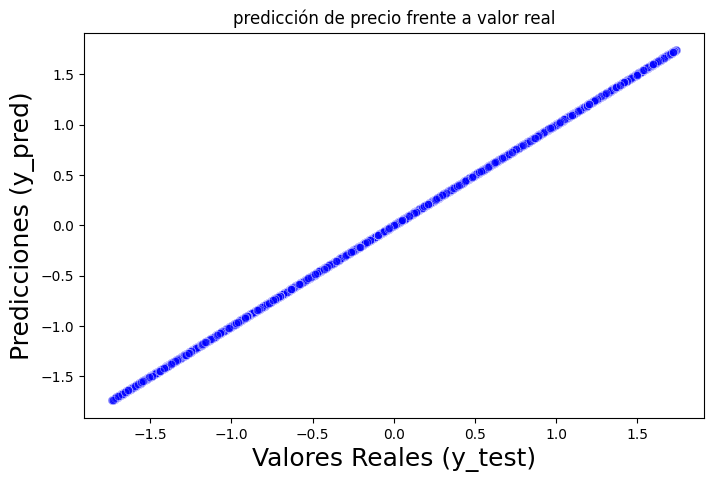

In [79]:
# Vamos a comparar que tan alejados estan los valores reales (y_test) y los valores predichos (yhat)
plt.figure(figsize = (8, 5))
sns.scatterplot(x = y_pred_rl, y = y_test_num, alpha = 0.5, color = "blue")
title= "predicción de precio frente a valor real"
plt.title(title)
plt.xlabel("Valores Reales (y_test)", size = 18)
plt.ylabel("Predicciones (y_pred)", size = 18)
plt.show()

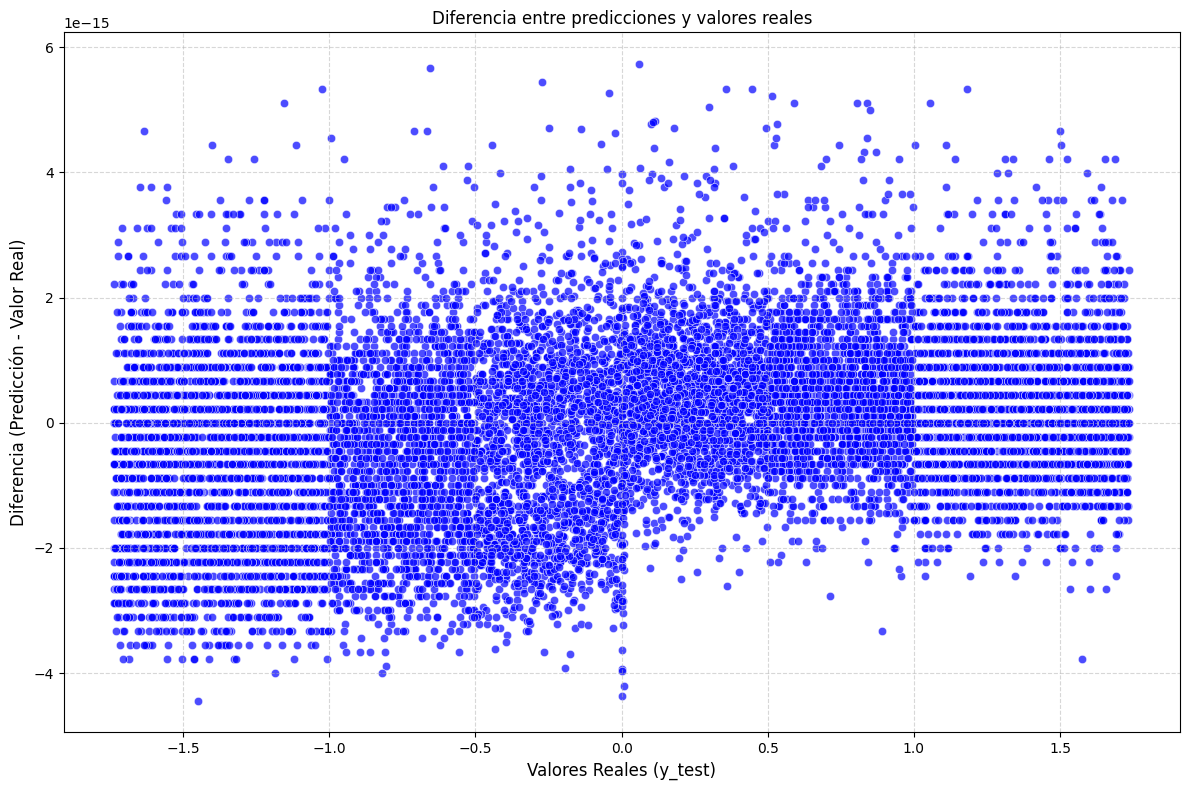

In [80]:
plt.figure(figsize=(12, 8))

differences = y_pred_rl - y_test_num  # Calcula las diferencias para todos los puntos

sns.scatterplot(x=y_test_num, y=differences, alpha=0.7, color="blue")
plt.title("Diferencia entre predicciones y valores reales")
plt.xlabel("Valores Reales (y_test)", size=12)
plt.ylabel("Diferencia (Predicción - Valor Real)", size=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("diferencia_prediccion_vs_valor_real_todos.png", bbox_inches='tight')
plt.show()

## Clasificación multiclase (20%)


### Predecir la columna 'room_type'

#### clasificación multiclase para predecir la columna 'room_type' en tu dataset.

**1. Preparación de los datos:**

* **Codificación de variables categóricas:**
    * Utiliza `pd.get_dummies()` para codificar las variables categóricas en variables numéricas (one-hot encoding).
    * Asegúrate de que la columna 'room_type' esté codificada correctamente.
* **Separación de características y variable objetivo:**
    * Separa las características (todas las columnas excepto 'room_type') de la variable objetivo ('room_type').
* **División en conjuntos de entrenamiento y prueba:**
    * Divide los datos en conjuntos de entrenamiento y prueba utilizando `train_test_split()`.

**2. Selección y entrenamiento del modelo:**

* **Modelos de clasificación multiclase:**
    * Algunos modelos adecuados para clasificación multiclase son:
        * Regresión Logística Multiclase (OneVsRestClassifier o Multinomial)
        * Árboles de Decisión
        * Random Forest Classifier
        * Gradient Boosting Classifier (por ejemplo, XGBoost, LightGBM)
        * Support Vector Machines (SVM)
* **Entrenamiento del modelo:**
    * Utiliza el método `fit()` del modelo seleccionado para entrenarlo con los datos de entrenamiento.

**3. Evaluación del modelo:**

* **Predicciones:**
    * Utiliza el método `predict()` del modelo entrenado para hacer predicciones en el conjunto de prueba.
* **Métricas de evaluación:**
    * Utiliza métricas de evaluación adecuadas para clasificación multiclase, como:
        * Precisión (Accuracy)
        * Precisión (Precision)
        * Recuperación (Recall)
        * Puntuación F1 (F1-score)
        * Matriz de confusión (Confusion Matrix)
        * Informe de clasificación (Classification Report)
* **Validación cruzada:**
    * Utiliza la validación cruzada para obtener una estimación más robusta del rendimiento del modelo.

**4. Ajuste de hiperparámetros (opcional):**

* **Búsqueda de hiperparámetros:**
    * Utiliza técnicas como `GridSearchCV` o `RandomizedSearchCV` para ajustar los hiperparámetros del modelo y encontrar la mejor combinación.


In [81]:
# tratamos de predecir el tipo de habitación
room_type_cols = ['room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']

X_mc = df_final.drop(room_type_cols, axis=1)
y_mc = df_final[room_type_cols]
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_mc, y_mc, test_size=0.2, random_state=42)

# 2. Selección y entrenamiento del modelo
model_mc = RandomForestClassifier(random_state=42)
model_mc.fit(X_train_mc, y_train_mc)

# 3. Evaluación del modelo
y_pred_mc = model_mc.predict(X_test_mc)
accuracy = accuracy_score(y_test_mc, y_pred_mc)
print(f"Precisión: {accuracy:.4f}")
print(classification_report(y_test_mc, y_pred_mc))

Precisión: 0.6809
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7508
           1       0.00      0.00      0.00        26
           2       0.69      0.62      0.65      6003
           3       0.93      0.04      0.08       324

   micro avg       0.72      0.68      0.70     13861
   macro avg       0.59      0.36      0.37     13861
weighted avg       0.72      0.68      0.69     13861
 samples avg       0.68      0.68      0.68     13861



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
'''y_pred_mc = model_mc.predict(X_test_mc)

for i, j in zip(y_pred_mc[:20], y_test_mc[:20]):
    print(f"Predicción: {i:20} \tValor real: {j} \tDiferencia: {i-j}")'''

'y_pred_mc = model_mc.predict(X_test_mc)\n\nfor i, j in zip(y_pred_mc[:20], y_test_mc[:20]):\n    print(f"Predicción: {i:20} \tValor real: {j} \tDiferencia: {i-j}")'

#### **Consideraciones adicionales:**

* **Desbalance de clases:**
    * Si las clases en 'room_type' están desbalanceadas, considera utilizar técnicas de sobremuestreo (oversampling) o submuestreo (undersampling) para equilibrar las clases.
* **Ingeniería de características:**
    * Considera crear nuevas características o transformar las existentes para mejorar el rendimiento del modelo.
* **Selección de características:**
    * Utiliza técnicas de selección de características para identificar las características más relevantes para predecir 'room_type'.
* **Interpretación del modelo:**
    * Si utilizas un modelo interpretable (como árboles de decisión), puedes analizar las reglas o la importancia de las características para comprender cómo el modelo toma decisiones.

#### Aquí te presento más opciones para realizar clasificación multiclase en tu dataframe, junto con algunas consideraciones importantes:

##### **1. Regresión Logística Multiclase:**

* **OneVsRestClassifier:**
    * Esta estrategia entrena un clasificador de regresión logística binario para cada clase, donde cada clasificador predice si una muestra pertenece o no a esa clase.
    * Es una buena opción cuando tienes muchas clases.
* **Multinomial:**
    * Esta estrategia entrena un único clasificador de regresión logística que puede distinguir entre todas las clases simultáneamente.
    * Es una buena opción cuando las clases son mutuamente excluyentes.


In [83]:
# 1. Regresión Logística Multiclase:
df_multiclase = df_final.dropna()
X_rlm = df_multiclase.drop(room_type_cols, axis=1)
y_rlm = df_multiclase[room_type_cols]
X_train_rlm, X_test_rlm, y_train_rlm, y_test_rlm = train_test_split(X_rlm, y_rlm, test_size=0.2, random_state=42)

# Modelo: Regresión Logística Multiclase (OneVsRestClassifier)
model_rlm = OneVsRestClassifier(LogisticRegression(random_state=42))
model_rlm.fit(X_train_rlm, y_train_rlm)

# Evaluación
y_pred_rlm = model_rlm.predict(X_test_rlm)
accuracy = accuracy_score(y_test_rlm, y_pred_rlm)
print(f"Precisión (Regresión Logística - OneVsRest): {accuracy:.4f}")
print(classification_report(y_test_rlm, y_pred_rlm))
#print(confusion_matrix(y_test_rlm, y_pred_rlm))

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Precisión (Regresión Logística - OneVsRest): 0.5787
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      5019
           1       0.00      0.00      0.00        19
           2       0.57      0.51      0.54      4166
           3       0.00      0.00      0.00       214

   micro avg       0.60      0.58      0.59      9418
   macro avg       0.30      0.29      0.29      9418
weighted avg       0.58      0.58      0.58      9418
 samples avg       0.58      0.58      0.58      9418



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

##### **2. Árboles de Decisión y Random Forest:**

* **Árboles de Decisión:**
    * Son modelos interpretables que pueden manejar datos categóricos y numéricos.
    * Pueden ser propensos al sobreajuste, especialmente con datos ruidosos.
* **Random Forest:**
    * Es un conjunto de árboles de decisión que mejora la precisión y reduce el sobreajuste.
    * Es un modelo robusto que suele funcionar bien en una variedad de problemas de clasificación.

In [84]:
#**2. Árboles de Decisión y Random Forest:**
df_adrf = pd.get_dummies(df_final, drop_first=True)
X_dtreeRF = df_final.drop(room_type_cols, axis=1)
y_dtreeRF = df_final[room_type_cols]
X_train_dtreeRF, X_test_dtreeRF, y_train_dtreeRF, y_test_dtreeRF = train_test_split(X_dtreeRF, y_dtreeRF, test_size=0.2, random_state=42)

# Modelo: Árbol de Decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_dtreeRF, y_train_dtreeRF)

# Evaluación (Árbol de Decisión)
y_pred_tree_dtreeRF = tree_model.predict(X_test_dtreeRF)
accuracy_tree = accuracy_score(y_test_dtreeRF, y_pred_tree_dtreeRF)
print(f"Precisión (Árbol de Decisión): {accuracy_tree:.4f}")
print(classification_report(y_test_dtreeRF, y_pred_tree_dtreeRF))
#print(confusion_matrix(y_test_dtreeRF, y_pred_tree_dtreeRF))

# Modelo: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_dtreeRF, y_train_dtreeRF)

# Evaluación (Random Forest)
y_pred_rf_dtreeRF = rf_model.predict(X_test_dtreeRF)
accuracy_rf = accuracy_score(y_test_dtreeRF, y_pred_rf_dtreeRF)
print(f"Precisión (Random Forest): {accuracy_rf:.4f}")
print(classification_report(y_test_dtreeRF, y_pred_rf_dtreeRF))
#print(confusion_matrix(y_test_dtreeRF, y_pred_rf_dtreeRF))

Precisión (Árbol de Decisión): 0.6198
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      7508
           1       0.55      0.46      0.50        26
           2       0.58      0.59      0.58      6003
           3       0.24      0.29      0.26       324

   micro avg       0.62      0.62      0.62     13861
   macro avg       0.51      0.50      0.50     13861
weighted avg       0.62      0.62      0.62     13861
 samples avg       0.62      0.62      0.62     13861

Precisión (Random Forest): 0.6809
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7508
           1       0.00      0.00      0.00        26
           2       0.69      0.62      0.65      6003
           3       0.93      0.04      0.08       324

   micro avg       0.72      0.68      0.70     13861
   macro avg       0.59      0.36      0.37     13861
weighted avg       0.72      0.68      0.69     13861
 samp

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Como ya hemos visto en apatados anteriores, Random Foresto da resultados aceptables

##### **4. Support Vector Machines (SVM):**

* **SVM con kernel RBF:**
    * Es un modelo potente que puede manejar datos no lineales.
    * Puede ser computacionalmente costoso para datasets grandes.

In [85]:
'''#**4. Support Vector Machines (SVM):**
df_svm = pd.get_dummies(df_final, drop_first=True)
X_svm = df_svm.drop(room_type_cols, axis=1)
y_svm = df_svm[room_type_cols]
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

# Modelo: SVM con kernel RBF
svm_model = SVC(random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Evaluación (SVM)
y_pred_svm = svm_model.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"Precisión (SVM): {accuracy_svm:.4f}")
print(classification_report(y_test_svm, y_pred_svm))
print(confusion_matrix(y_test_svm, y_pred_svm))'''

'#**4. Support Vector Machines (SVM):**\ndf_svm = pd.get_dummies(df_final, drop_first=True)\nX_svm = df_svm.drop(room_type_cols, axis=1)\ny_svm = df_svm[room_type_cols]\nX_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)\n\n# Modelo: SVM con kernel RBF\nsvm_model = SVC(random_state=42)\nsvm_model.fit(X_train_svm, y_train_svm)\n\n# Evaluación (SVM)\ny_pred_svm = svm_model.predict(X_test_svm)\naccuracy_svm = accuracy_score(y_test_svm, y_pred_svm)\nprint(f"Precisión (SVM): {accuracy_svm:.4f}")\nprint(classification_report(y_test_svm, y_pred_svm))\nprint(confusion_matrix(y_test_svm, y_pred_svm))'

##### **5. Redes Neuronales:**

* **Redes Neuronales Densas:**
    * Son modelos muy flexibles que pueden aprender relaciones complejas entre las características y la variable objetivo.
    * Requieren una cuidadosa selección de la arquitectura y los hiperparámetros.

In [92]:
'''##### **5. Redes Neuronales (Keras):**
df_rn = pd.get_dummies(df_final, drop_first=True)
X_rnk = df_rn.drop(room_type_cols, axis=1).values #convertimos a numpy array
y_rnk = pd.get_dummies(df_rn[room_type_cols]).values #convertimos a numpy array y one hot encoding

X_train_rnk, X_test_rnk, y_train_rnk, y_test_rnk = train_test_split(X_rnk, y_rnk, test_size=0.2, random_state=42)

# Modelo: Red Neuronal Densa
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_rnk.shape[1],)),
    keras.layers.Dense(len(y[0]), activation='softmax')  # Salida multiclase
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_rnk, y_train_rnk, epochs=10, batch_size=32, verbose=0)

# Evaluación (Red Neuronal)
y_pred_nn = model.predict(X_test_rnk)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
y_test_classes = np.argmax(y_test_rnk, axis=1)

accuracy_nn = accuracy_score(y_test_classes, y_pred_nn_classes)
print(f"Precisión (Red Neuronal): {accuracy_nn:.4f}")
print(classification_report(y_test_classes, y_pred_nn_classes))
print(confusion_matrix(y_test_classes, y_pred_nn_classes))'''


'##### **5. Redes Neuronales (Keras):**\ndf_rn = pd.get_dummies(df_final, drop_first=True)\nX_rnk = df_rn.drop(room_type_cols, axis=1).values #convertimos a numpy array\ny_rnk = pd.get_dummies(df_rn[room_type_cols]).values #convertimos a numpy array y one hot encoding\n\nX_train_rnk, X_test_rnk, y_train_rnk, y_test_rnk = train_test_split(X_rnk, y_rnk, test_size=0.2, random_state=42)\n\n# Modelo: Red Neuronal Densa\nmodel = keras.Sequential([\n    keras.layers.Dense(128, activation=\'relu\', input_shape=(X_train_rnk.shape[1],)),\n    keras.layers.Dense(len(y[0]), activation=\'softmax\')  # Salida multiclase\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\nmodel.fit(X_train_rnk, y_train_rnk, epochs=10, batch_size=32, verbose=0)\n\n# Evaluación (Red Neuronal)\ny_pred_nn = model.predict(X_test_rnk)\ny_pred_nn_classes = np.argmax(y_pred_nn, axis=1)\ny_test_classes = np.argmax(y_test_rnk, axis=1)\n\naccuracy_nn = accuracy_score(y_test_class

##### La matriz de confusión y el informe de clasificación (`classification_report`) se utilizan principalmente en problemas de **clasificación**, no en problemas de regresión.

Aquí te explico por qué:

**Clasificación vs. Regresión:**

* **Clasificación:**
    * El objetivo es predecir una etiqueta o categoría discreta.
    * Ejemplos: predecir si un correo electrónico es spam o no, predecir el tipo de habitación (como en tu caso), predecir si un paciente tiene una enfermedad o no.
* **Regresión:**
    * El objetivo es predecir un valor numérico continuo.
    * Ejemplos: predecir el precio de una casa, predecir la temperatura, predecir las ventas de un producto.

**Matriz de confusión:**

* La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase en un problema de clasificación.
* No tiene sentido en regresión porque las predicciones y los valores reales son números continuos, no categorías.

**Informe de clasificación (`classification_report`):**

* El informe de clasificación proporciona métricas de evaluación (precisión, recuperación, puntuación F1) para cada clase en un problema de clasificación.
* Estas métricas se basan en la matriz de confusión y, por lo tanto, tampoco son aplicables a la regresión.

**En resumen:**

* La matriz de confusión y el informe de clasificación son herramientas de evaluación diseñadas específicamente para problemas de clasificación.
* En problemas de regresión, se utilizan otras métricas de evaluación, como el error cuadrático medio (MSE), la raíz del error cuadrático medio (RMSE), el error absoluto medio (MAE) y el coeficiente de determinación (R²).


In [87]:
df_transformed.columns

Index(['lat', 'long', 'instant_bookable', 'construction_year', 'price',
       'service_fee', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365', 'review_year',
       'review_month', 'review_day', 'price_scaled',
       'number_of_reviews_scaled', 'cluster',
       'host_identity_verified_unconfirmed', 'host_identity_verified_verified',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'cluster_1',
       'cluster_2'],
      dtype='object')

##### **Explicación del código:**

1.  **Carga de datos:**
    * Carga tu dataset y realiza la codificación de variables categóricas.

2.  **Selección y entrenamiento del modelo:**
    * Entrena un modelo de clasificación (en este caso, Random Forest).

3.  **Evaluación del modelo:**
    * Realiza predicciones en el conjunto de prueba y calcula la precisión.

4.  **Matriz de confusión:**
    * `confusion_matrix(y_test, y_pred)` calcula la matriz de confusión.
    * `print("Matriz de confusión:\n", cm)` imprime la matriz de confusión.

5.  **Informe de clasificación:**
    * `classification_report(y_test, y_pred)` genera el informe de clasificación.
    * `print("Informe de clasificación:\n", cr)` imprime el informe de clasificación.

6.  **Visualización de la matriz de confusión:**
    * Se utiliza `seaborn.heatmap()` para visualizar la matriz de confusión.

**¿En qué columnas es mejor usarlos?**

La matriz de confusión y el informe de clasificación son más útiles cuando la variable objetivo es **categórica**, es decir, cuando intentas predecir una etiqueta o categoría.

En tu dataset, las columnas donde son más útiles son:

* **'room\_type'**: Esta es la columna objetivo en el ejemplo de clasificación multiclase. Cada valor representa un tipo de habitación diferente.
* Cualquier otra columna que represente categorías o etiquetas (por ejemplo, 'neighbourhood', 'cancellation\_policy', etc.).

**¿Por qué son útiles?**

* **Matriz de confusión:**
    * Te permite ver cuántas predicciones son correctas e incorrectas para cada clase.
    * Puedes identificar qué clases se confunden con mayor frecuencia.
    * Es especialmente útil cuando tienes clases desbalanceadas.
* **Informe de clasificación:**
    * Proporciona métricas detalladas (precisión, recuperación, puntuación F1) para cada clase.
    * Puedes evaluar el rendimiento del modelo para cada clase individualmente.
    * Es útil para identificar qué clases son más difíciles de predecir.

**En resumen:**

* Utiliza la matriz de confusión y el informe de clasificación cuando la variable objetivo sea categórica.
* Son herramientas valiosas para evaluar el rendimiento de modelos de clasificación.
* Te ayudan a identificar patrones y errores en las predicciones del modelo.


#####

**1. `df_transformed_num = numeric_pipeline.fit_transform(df[numerical_columns_sin_price])`**

* **`df[numerical_columns_sin_price]`:**
    * Esta parte selecciona las columnas numéricas de tu DataFrame `df` que están especificadas en la lista `numerical_columns_sin_price`. Esto crea un nuevo DataFrame que contiene solo las columnas numéricas que deseas transformar.
* **`numeric_pipeline.fit_transform(...)`:**
    * `numeric_pipeline` es un objeto `Pipeline` que has creado previamente para realizar transformaciones numéricas (imputación, escalado, etc.).
    * **`fit(...)`:**
        * El método `fit()` calcula los parámetros necesarios para las transformaciones en el pipeline. Por ejemplo, para `StandardScaler`, calcula la media y la desviación estándar de las columnas. Para `SimpleImputer`, calcula la mediana o la media.
        * Es importante que el fit se realice solo con los datos de entrenamiento, para evitar data leakage.
    * **`transform(...)`:**
        * El método `transform()` aplica las transformaciones calculadas por `fit()` a los datos.
    * **`fit_transform(...)`:**
        * Este método combina `fit()` y `transform()` en un solo paso. Es eficiente cuando quieres calcular los parámetros y aplicar las transformaciones al mismo conjunto de datos.
* **`df_transformed_num = ...`:**
    * El resultado de `fit_transform()` es un array de NumPy que contiene los datos numéricos transformados. Este array se asigna a la variable `df_transformed_num`.

**En resumen:** Esta línea aplica las transformaciones numéricas definidas en `numeric_pipeline` a las columnas numéricas especificadas en `numerical_columns_sin_price` y almacena el resultado en `df_transformed_num`. El fit se realiza con los datos pasados a la función.

**2. `df_transformed_num = numeric_pipeline.transform(df)`**

* **`numeric_pipeline.transform(df)`:**
    * Esta línea utiliza el método `transform()` del `numeric_pipeline` para aplicar las transformaciones a todo el DataFrame `df`.
    * **`transform(...)`:**
        * Aplica las transformaciones que ya han sido calculadas por un previo `fit()` a los datos.
        * Es importante que el fit se haya realizado previamente, con los datos de entrenamiento.
* **`df_transformed_num = ...`:**
    * El resultado de `transform()` es un array de NumPy que contiene los datos transformados. Este array se asigna a la variable `df_transformed_num`.

**Diferencias clave:**

* **`fit_transform()` vs. `transform()`:**
    * `fit_transform()` calcula los parámetros de las transformaciones y las aplica al mismo conjunto de datos.
    * `transform()` aplica las transformaciones utilizando los parámetros calculados previamente por `fit()`.
* **Columnas seleccionadas:**
    * La primera linea solo transforma las columnas numericas especificadas en `numerical_columns_sin_price`.
    * La segunda linea intenta transformar todas las columnas del DataFrame `df`. Esto puede causar errores si el pipeline no está diseñado para manejar todas las columnas (por ejemplo, columnas categóricas).
* **Uso típico:**
    * `fit_transform()` se usa típicamente en el conjunto de entrenamiento para aprender las transformaciones.
    * `transform()` se usa típicamente en el conjunto de prueba o en nuevos datos para aplicar las transformaciones aprendidas en el conjunto de entrenamiento.

**Problemas potenciales con la segunda línea:**

* Si tu `numeric_pipeline` solo está diseñado para manejar columnas numéricas, intentar aplicarlo a todo el DataFrame `df` (que probablemente contenga columnas categóricas) generará errores.
* Es muy importante que el fit se realice solo con los datos de entrenamiento, y el transform con los datos de test, o con datos nuevos.

In [88]:
df_transformed.head(1)

,lat,long,instant_bookable,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,...,neighbourhood_group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster_1,cluster_2
0,-1.439649,-0.462349,-0.993829,1.304789,1.030521,1.028444,1.23476,-0.365215,-0.657858,0.540212,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0


In [89]:
# Matriz de confusión por tipo de habitación OK!!!!!!!
room_type_cols = ['room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']

# Preparación de los datos
X = df_transformed.drop(room_type_cols, axis=1)  # Variables predictoras
y = df_transformed[room_type_cols]  # Variables objetivo (one-hot encoded)

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo (MultiOutputClassifier)
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = model.predict(X_test)

# Métricas de evaluación
for i, col in enumerate(room_type_cols):
    print(f"Clasificación para {col}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))
    print(f"Matriz de Confusión para {col}:")
    print(multilabel_confusion_matrix(y_test.iloc[:, i], y_pred[:, i]))

Clasificación para room_type_Entire home/apt:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      6432
         1.0       0.85      0.86      0.85      7429

    accuracy                           0.84     13861
   macro avg       0.84      0.84      0.84     13861
weighted avg       0.84      0.84      0.84     13861

Matriz de Confusión para room_type_Entire home/apt:
[[[6357 1072]
  [1090 5342]]

 [[5342 1090]
  [1072 6357]]]
Clasificación para room_type_Hotel room:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13832
         1.0       1.00      0.10      0.19        29

    accuracy                           1.00     13861
   macro avg       1.00      0.55      0.59     13861
weighted avg       1.00      1.00      1.00     13861

Matriz de Confusión para room_type_Hotel room:
[[[    3    26]
  [    0 13832]]

 [[13832     0]
  [   26     3]]]
Clasificación para room_type_Pri

## Comparar resultados de modelos con validación cruzada (10 %)


### Mostrar un dataframe de resultados con las métricas calculadas


### Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas



### **4. Ajuste de hiperparámetros (opcional):**

* **Validación cruzada:** Utiliza la validación cruzada para evaluar el rendimiento del modelo en diferentes subconjuntos de datos y obtener una estimación más robusta del rendimiento.
* **Búsqueda de hiperparámetros:** Utiliza técnicas como `GridSearchCV` o `RandomizedSearchCV` para ajustar los hiperparámetros del modelo y encontrar la mejor combinación.

**5. Análisis de errores (opcional):**

* **Residuos:** Analiza los residuos (la diferencia entre las predicciones y los valores reales) para identificar patrones o errores sistemáticos en el modelo.
* **Importancia de las características:** Si utilizas un modelo basado en árboles (como Random Forest o Gradient Boosting), puedes inspeccionar la importancia de las características para comprender qué características son más influyentes en las predicciones.

**6. Mejora del modelo (opcional):**

* **Ingeniería de características:** Considera crear nuevas características o transformar las existentes para mejorar el rendimiento del modelo.
* **Recopilación de datos:** Si es posible, considera recopilar datos adicionales que puedan ser relevantes para predecir el precio.

In [ ]:
'''X = df_transformed.drop('price', axis=1)
y = df_transformed['price']

# Codificar la variable objetivo si es categórica
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Definir los modelos a comparar
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Métricas a calcular (sin tiempos)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Realizar la validación cruzada y almacenar los resultados
results = []
for name, model in models.items():
    scores = cross_validate(model, X, y_encoded, cv=5, scoring=scoring, return_times=True)  # Añadir return_times=True
    for metric in scoring:
        results.append({
            'Model': name,
            'Metric': metric,
            'Mean': np.mean(scores[f'test_{metric}']),
            'Std': np.std(scores[f'test_{metric}'])
        })
    # Añadir tiempos de ajuste y puntuación
    results.append({
        'Model': name,
        'Metric': 'fit_time',
        'Mean': np.mean(scores['fit_time']),
        'Std': np.std(scores['fit_time'])
    })
    results.append({
        'Model': name,
        'Metric': 'score_time',
        'Mean': np.mean(scores['score_time']),
        'Std': np.std(scores['score_time'])
    })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar DataFrame
print(results_df)

# Opcional: Mostrar boxplots de los resultados de validación cruzada
plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Mean', hue='Model', data=results_df)
plt.title('Resultados de Validación Cruzada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()'''

TypeError: got an unexpected keyword argument 'return_times'

In [99]:
print(type(X_train_final_ohe_mms))
print(type(X_test_final_ohe_mms))
print(type(y_train_all))
print(type(y_test_all))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [98]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Asumiendo que tienes X_train_df, X_test_df, y_train_series e y_test_series

# 1. Combinar los conjuntos de datos
X_combined = pd.concat([X_train_final_ohe_mms, X_test_final_ohe_mms], ignore_index=True)
y_combined = pd.concat([y_train_all, y_test_all], ignore_index=True)

# 2. Codificar la variable objetivo si es categórica
le = LabelEncoder()
y_combined_encoded = le.fit_transform(y_combined)

# 3. Realizar la validación cruzada
model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X_combined, y_combined_encoded, cv=5)  # 5-fold cross-validation
results = cross_validate(model, X_combined, y_combined_encoded, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

# Imprimir los resultados
print("Puntuaciones de validación cruzada:", scores)
print("Precisión media:", np.mean(scores))
print(results)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Puntuaciones de validación cruzada: [0.39102518 0.38438785 0.34276026 0.35646779 0.37132963]
Precisión media: 0.3691941418368083
{'fit_time': array([197.11245799, 196.60271025, 184.02900553, 210.58039045,
       197.46585417]), 'score_time': array([23.62965345, 24.05514526,  0.        , 23.16305161, 21.45664096]), 'test_accuracy': array([0.39102518, 0.38438785,        nan, 0.35646779, 0.37132963]), 'test_precision_macro': array([0.38126473, 0.37595806,        nan, 0.34701248, 0.36457075]), 'test_recall_macro': array([0.37694797, 0.37131617,        nan, 0.34234849, 0.35735662]), 'test_f1_macro': array([0.37077653, 0.36452362,        nan, 0.33588516, 0.35202501])}


c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\L

In [100]:
df_model = pd.DataFrame(results)
df_model['modelo'] = model

df_resultados_cross = pd.concat(df_model, ignore_index=True) 

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [101]:
df_resultados_cross.sort_values('test_r2', ascending=False).head(5)

NameError: name 'df_resultados_cross' is not defined

In [102]:
model = LinearRegression()
results = cross_validate(model, X_train_final_ohe_mms, y_train_all, 
               scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
)
print('fit_time', results['fit_time'].mean())
print('score_time', results['score_time'].mean())
print('test_r2', results['test_r2'].mean())
print('test_neg_mean_absolute_error', results['test_neg_mean_absolute_error'].mean())
print('test_neg_mean_squared_error', results['test_neg_mean_squared_error'].mean())
print('test_neg_mean_absolute_percentage_error', results['test_neg_mean_absolute_percentage_error'].mean())
print('test_neg_root_mean_squared_error', results['test_neg_root_mean_squared_error'].mean())

fit_time 0.041000986099243165
score_time 0.003400564193725586
test_r2 1.0
test_neg_mean_absolute_error -2.9280884778788603e-13
test_neg_mean_squared_error -1.5194175184346587e-25
test_neg_mean_absolute_percentage_error -8.131363374546391e-16
test_neg_root_mean_squared_error -3.7956318910556956e-13


In [103]:
X= X_train_final_ohe_mms
y= y_train_all
models = {
    'LogisticRegression': LinearRegression(n_jobs=10),
    'KNN': KNeighborsRegressor(),
    'DT': DecisionTreeRegressor(),
    'SVC': SVR(),
    'RandomForest': RandomForestRegressor()
}

df_list = []
for name, model in models.items(): 
    
    results = cross_validate(model, X_train, y_train, cv=5, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'])
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_resultados = pd.concat(df_list, ignore_index=True)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1408, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1485, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (44355, 4) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1408, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1485, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (44356, 4) instead.


In [104]:
df_resultados

,Modelo,Preprocesado,R2,MAE,RMSE,MAPE
0,LinearRegression,OneHotEncoder,1.000000,2.732060e-13,3.710784e-13,9.830486e-16
1,KNN,OneHotEncoder,0.991370,1.220852e+01,3.072171e+01,3.474514e-02
2,SVR,OneHotEncoder,0.302544,2.384625e+02,2.761832e+02,8.507357e-01
3,DecisionTree,OneHotEncoder,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
4,RandomForest,OneHotEncoder,1.000000,9.212900e-04,2.762292e-02,2.153158e-06
5,LinearRegression,OneHotEncoder+MinMaxScaler,1.000000,4.836730e-13,5.938713e-13,1.803472e-15
6,KNN,OneHotEncoder+MinMaxScaler,0.929054,6.723309e+01,8.808532e+01,2.230652e-01
7,SVR,OneHotEncoder+MinMaxScaler,0.992398,1.708327e+01,2.883377e+01,6.623112e-02
8,DecisionTree,OneHotEncoder+MinMaxScaler,1.000000,2.885795e-04,2.402413e-02,7.906720e-07
9,RandomForest,OneHotEncoder+MinMaxScaler,1.000000,9.212900e-04,2.762292e-02,2.153158e-06


In [105]:
df_pivot = df_resultados.groupby('modelo').mean().sort_values('test_r2', ascending=False)
df_pivot

KeyError: 'modelo'

In [106]:
df_resultados_times = df_resultados[['modelo', 'fit_time', 'score_time']]
df_resultados_scores = df_resultados[['modelo', 'test_r2', 'test_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'test_neg_mean_absolute_percentage_error', 'test_neg_root_mean_squared_error']]

KeyError: "None of [Index(['modelo', 'fit_time', 'score_time'], dtype='object')] are in the [columns]"

In [107]:
# DATAFRAMES DE TIMES
df_times = df_resultados_times.melt(id_vars='modelo', var_name='time_type', value_name='time_seconds')
df_times.head(3)

NameError: name 'df_resultados_times' is not defined

In [108]:
# DATAFRAMES DE SCORES
df_scores = df_resultados_scores.melt(id_vars='modelo', var_name='metric', value_name='score')
df_scores.head(3)

NameError: name 'df_resultados_scores' is not defined

In [109]:
# BOXPLOT PARA TIMES
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 18))
sns.boxplot(df_times, x='time_seconds', y='time_type', hue='modelo');

NameError: name 'df_times' is not defined

<Figure size 3000x1800 with 0 Axes>

In [110]:
plt.figure(figsize=(12, 4))
sns.boxplot(df_scores, x='score', y='metric', hue='modelo');

NameError: name 'df_scores' is not defined

<Figure size 1200x400 with 0 Axes>

In [111]:
sns.heatmap(df_pivot.drop(columns=['fit_time','score_time']), annot=True, cmap='viridis')

NameError: name 'df_pivot' is not defined

In [112]:
# dividir en dos dataframes, unos para times y otro para scores
df_resultados_times = df_resultados[['modelo', 'fit_time', 'score_time']]
df_resultados_scores = df_resultados[['modelo', 'test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc_ovr']]

KeyError: "None of [Index(['modelo', 'fit_time', 'score_time'], dtype='object')] are in the [columns]"

In [113]:
# DATAFRAMES DE TIMES
df_times = df_resultados_times.melt(id_vars='modelo', var_name='time_type', value_name='time_seconds')
df_times.head(3)

NameError: name 'df_resultados_times' is not defined

In [114]:
# DATAFRAMES DE SCORES
df_scores = df_resultados_scores.melt(id_vars='modelo', var_name='metric', value_name='score')
df_scores.head(3)

NameError: name 'df_resultados_scores' is not defined

In [115]:
# BOXPLOT PARA TIMES
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 18))
sns.boxplot(df_times, x='time_seconds', y='time_type', hue='modelo');

NameError: name 'df_times' is not defined

<Figure size 3000x1800 with 0 Axes>

In [116]:
plt.figure(figsize=(12, 8))
sns.boxplot(df_scores, x='metric', y='score', hue='modelo');

NameError: name 'df_scores' is not defined

<Figure size 1200x800 with 0 Axes>

## Conclusiones: 

Este ejercicio requería mucho más tiempo de codificación y de computación que los demás.

He querido hacer unos apuntes que me sirvan en el futuro, usando varias opciones de imputer, escalado, modelado, etc

Lamento que no esté mejor desarrollado y eplicado, hay muchos fallos.

## * Opcional:


###    * Uso de pipelines opcional:


####        * Opción 1: hacer las transformaciones por separado manualmente


####        * Opción 2: hacer las transformaciones con pipelines


####        * Opción 3: una primera parte con transformaciones manuales y una segunda parte con Pipeline


###        * En ambos casos sería interesante calcular las métricas para ver qué técnicas de preprocesado van mejor


###    * Vectorizar la columna texto 'name' y usar TruncatedSVD


###    * Clasificación multiclase 'room_type' o regresión sobre price con TensorFlow-Keras


###    * SMOTE si hay desbalanceo para el problema de clasificación multiclase 'room_type'


###    * Crear un apartado independiente donde se eliminen filas cuya last_review sea null, y trata la fecha por ejemplo con df['last_review].dt.year o month o day para sacar año mes y día y poder usarlos como 3 columnas de entrada.


###    * Transformar distribución de la variable objetivo 'price': En caso de querer transformar precio:


####        * manual sin pipeline:


#####            * train_test_split


#####            * hacer transformación de precio (por ejemplo logarítmica) para y_train


#####            * hacer fit: model.fit(X_train, y_train_log)


#####            * y_pred_log = model.predict


#####            * deshacer transformación precio: inverse_transform o np.exp(y_pred_log) para obtener y_pred normal


####        * automática con pipeline:


#####            * requiere de usar clase especial combinada con el pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html


###    * GridSearchCV para buscar mejores párametros en algún modelo